### Check means and medians (change to median not made in important features sections and standard deviations still present throughout)

### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns

import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks.similarity import mz_similarity

import scaling as sca
import multianalysis as ma

In [2]:
%matplotlib inline

### Similarity analysis with the following peak alignment: 
#### 1st alignment: min_sample = 6 - NAME: 1-6
#### 2nd alignment: min_sample = 13 - NAME: 1-13 or 2 - Name: 1-2

To better understand the functions used outside of normal Python packages, see scaling.py, multianalysis.py where they are better described.

## Similarity analysis - "True" Non Bias

aligned_all_neg = negative dataset alignment 1-6 / aligned_neg - binary matrix equivalent

aligned_all_pos = positive dataset alignment 1-6 / aligned_pos - binary matrix equivalent

aligned_all_neg2 = negative dataset alignment 1-2 or 1-13 / aligned_neg2 - binary matrix equivalent

aligned_all_pos2 = positive dataset alignment 1-2 or 1-13 / aligned_pos2 - binary matrix equivalent

#### Read aligned data 

Function needed since labels and samples were getting switched with the read_data_csv from metabolinks (dataio.py) function - needed to swap index levels (this seemed easier than the swaplevel function in pandas).

#### Only needed for aligned files made with the older version of the align function

In [3]:
aligned_all_pos = pd.HDFStore('alignments.h5').get('all_1ppm_min6_pos')
aligned_all_neg = pd.HDFStore('alignments.h5').get('all_1ppm_min6_neg')

### Compute m/z similarities - Not present in yeast_new (maybe take out in future versions except first cell)

In [4]:
sim_pos = mz_similarity(aligned_all_pos, has_labels = True)
sim_neg = mz_similarity(aligned_all_neg, has_labels = True)

In [5]:
print(sim_pos)


Sample similarity, counts of common peaks
          14   15   16   29   30   31    8    9   10   23  ...   34  10713-1  \
14       339  198  179  187  203  173  195  176  186  151  ...  166       11   
15       198  470  199  259  259  251  226  223  224  206  ...  232       12   
16       179  199  366  211  207  210  193  200  192  170  ...  176       13   
29       187  259  211  636  328  362  226  240  234  285  ...  322       17   
30       203  259  207  328  612  318  232  241  249  279  ...  320       17   
31       173  251  210  362  318  626  219  234  234  269  ...  302       22   
8        195  226  193  226  232  219  433  231  219  185  ...  201       14   
9        176  223  200  240  241  234  231  446  245  202  ...  222       18   
10       186  224  192  234  249  234  219  245  470  199  ...  233       15   
23       151  206  170  285  279  269  185  202  199  723  ...  406       23   
24       152  196  167  280  268  267  193  197  202  481  ...  408       23 

In [6]:
print(sim_neg)


Sample similarity, counts of common peaks
          14   15   16   29   30   31    8    9   10   23  ...   34  10713-1  \
14       359  188  231  184  181  173  156  175  172   39  ...  150        8   
15       188  252  153  134  124  114  128  131  147   17  ...  154        6   
16       231  153  357  201  200  193  179  212  202   79  ...  144        6   
29       184  134  201  455  391  329  138  134  122   75  ...  232       18   
30       181  124  200  391  477  329  140  137  132   75  ...  257       24   
31       173  114  193  329  329  412  126  126  124   84  ...  180       19   
8        156  128  179  138  140  126  343  271  284   89  ...  132        5   
9        175  131  212  134  137  126  271  368  298   87  ...  138        5   
10       172  147  202  122  132  124  284  298  370   88  ...  140        4   
23        39   17   79   75   75   84   89   87   88  202  ...   20       12   
24        57   29   94   96   92  103  103   97  102  156  ...   30       12 

### Clustermap peak list function

In [7]:
def clustermap_peak_list(aligned):
    aligned_01 = aligned.copy()
    aligned_01[aligned_01.notnull()] = 1
    aligned_01[aligned_01.isnull()] = 0
    aligned_01.columns = aligned_01.cdl.samples

    ulabels = aligned.cdl.unique_labels
    n = len(ulabels)
    
    p = sns.color_palette() + sns.color_palette("Set1", n_colors=n-10, desat=.5)
    sample_to_labels = pd.Series(aligned.cdl.labels, index=aligned.cdl.samples)
    label_colors = pd.Series(p, index=ulabels)
    sample_colors = sample_to_labels.map(label_colors)
    
    g = sns.clustermap(aligned_01, metric="jaccard", figsize=(15, 20), 
                       row_cluster=False,
                       col_colors=sample_colors,
                       yticklabels=False)
    # fix bug in seaborn, error in clustermap if cbar == False
    ax=g.cax; aax=ax.clear(); aax = ax.axis('off'); 

    # draw legend
    lpatches = [mpatches.Patch(color=c, label=lbl) for (lbl, c) in label_colors.iteritems()]
    leg = plt.legend(handles=lpatches, fontsize=20)
    return g
    

Sample HC, NEGATIVE mode


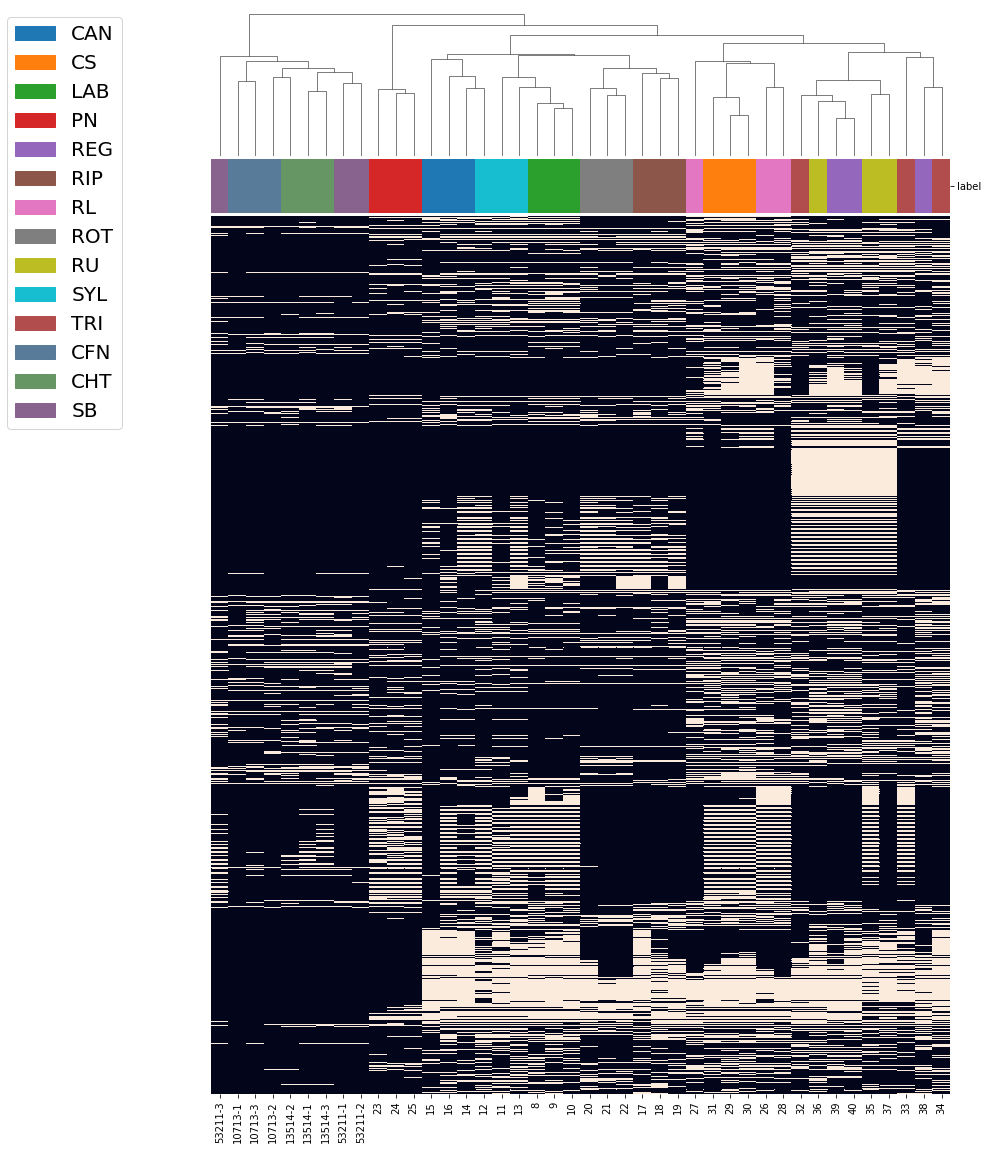

In [8]:
print('Sample HC, NEGATIVE mode')
g = clustermap_peak_list(aligned_all_neg)

Sample HC, POSITIVE mode


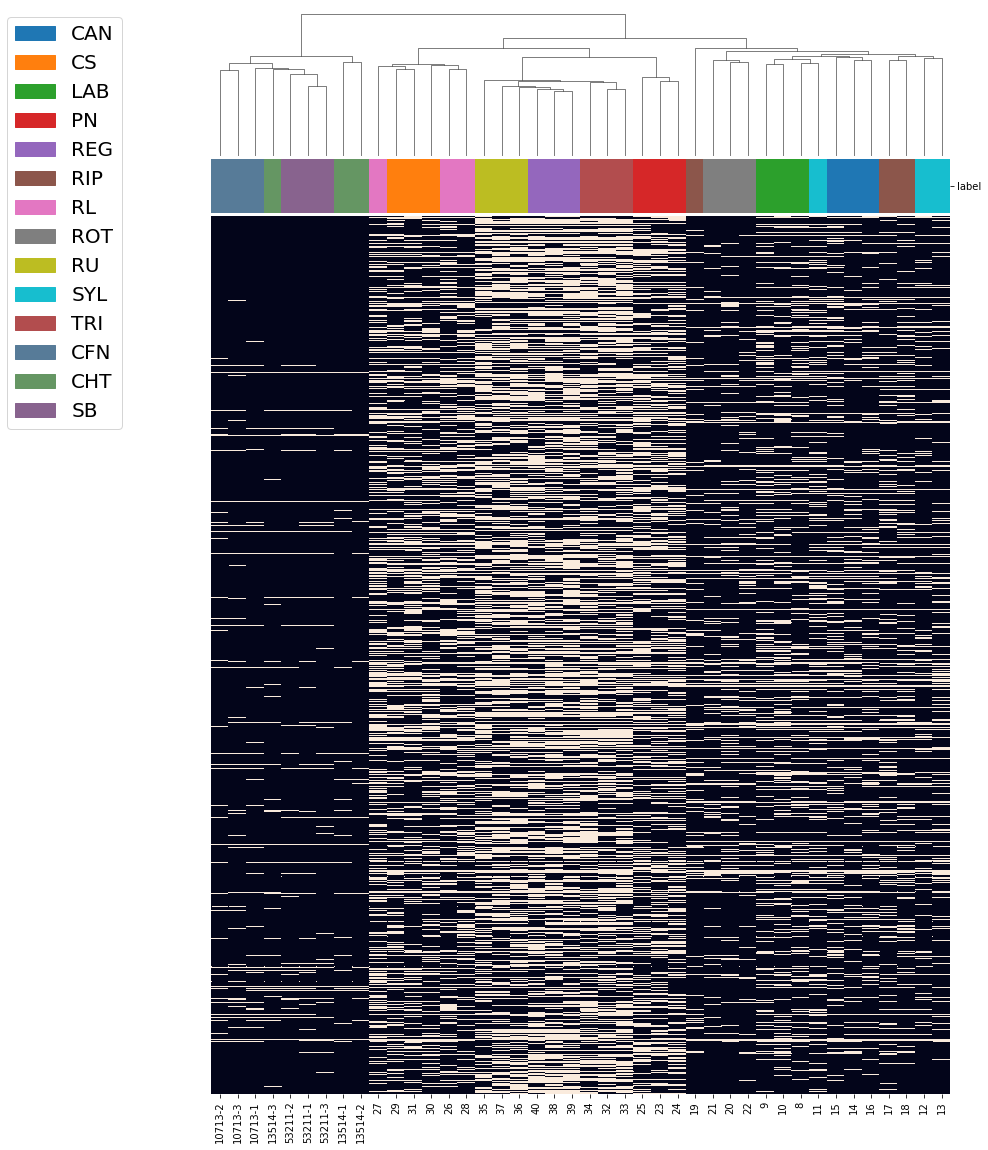

In [9]:
print('Sample HC, POSITIVE mode')
g = clustermap_peak_list(aligned_all_pos)

### Global metadata for consistency between tables and plots

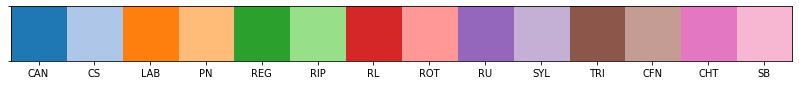

In [10]:
sample_names = aligned_all_neg.cdl.samples
all_labels = aligned_all_neg.cdl.labels
unique_labels = aligned_all_neg.cdl.unique_labels

# customize these colors
colours = sns.color_palette('tab20', 14)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

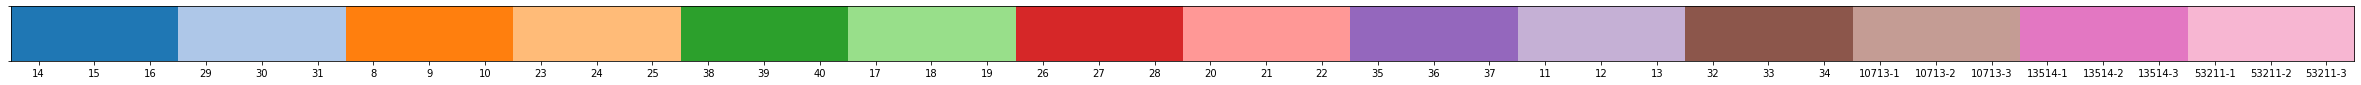

In [11]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Data transformations

### Each Dataset is transformed to binary or ...

3/4 types of processing are made:

(Imp (Ionly) - Only Missing Value Imputation).

P - Missing Value Imputation and Pareto Scaling.

NP - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

NGP - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling.

In [12]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

def compute_transf(dataset, norm_ref=None, lamb=None):
    intensities = dataset
    dicto = {}
    
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    dicto['binary'] = df_to_bool(intensities)
    dicto['Ionly'] = imputed
    dicto['P'] = P
    dicto['NP'] = NP
    dicto['NGP'] = NGP
    
    return dicto

In [13]:
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg, 554.2615) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos, 556.2771)
print(RefEst_Pos)

(554.2620199999996, 0.0005199999995966209)
(556.2765711904766, 0.0005288095234163848)


In [14]:
# Negative mode dataset
treat_neg = compute_transf(aligned_all_neg, norm_ref = 554.2620199999996)

# Positive mode dataset
treat_pos = compute_transf(aligned_all_pos, norm_ref = 556.2765711904766)

## Similarity analysis (Jaccard)

In [15]:
def plot_jaccard_sims(dataset, title=''):
    intensities = dataset
    sims = mz_similarity(intensities, has_labels=True)
    #grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
    f, ax = plt.subplots(1,2, figsize=(14, 7), constrained_layout=True) # gridspec_kw=grid_kws,

    hm = sns.heatmap(sims.sample_similarity_jaccard, annot=False, square=True, ax=ax[0], cmap='YlGnBu', cbar=None)
    hm = sns.heatmap(sims.label_similarity_jaccard, annot=True, square=True, ax=ax[1], cmap='YlGnBu')
    
    #Correction for heatmap bug in latest version of seaborn
    bottom, top = ax[0].get_ylim()
    ax[0].set_ylim(bottom + 0.5, top - 0.5)
    bottom, top = ax[1].get_ylim()
    ax[1].set_ylim(bottom + 0.5, top - 0.5)
    
    ax[0].set_title('Sample similarity')
    ax[1].set_title('Group similarity')
    f.suptitle(title, fontsize=16)

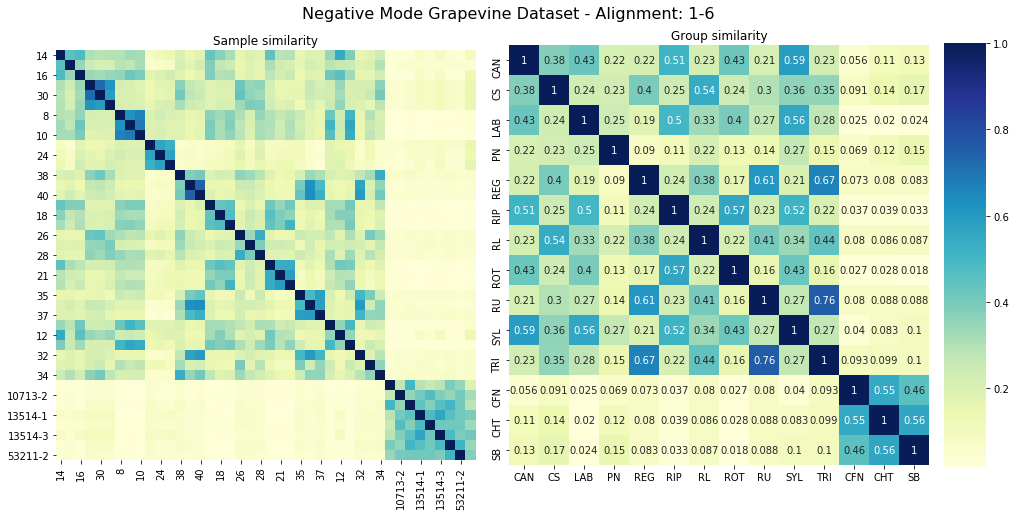

In [16]:
plot_jaccard_sims(aligned_all_neg, 'Negative Mode Grapevine Dataset - Alignment: 1-6')

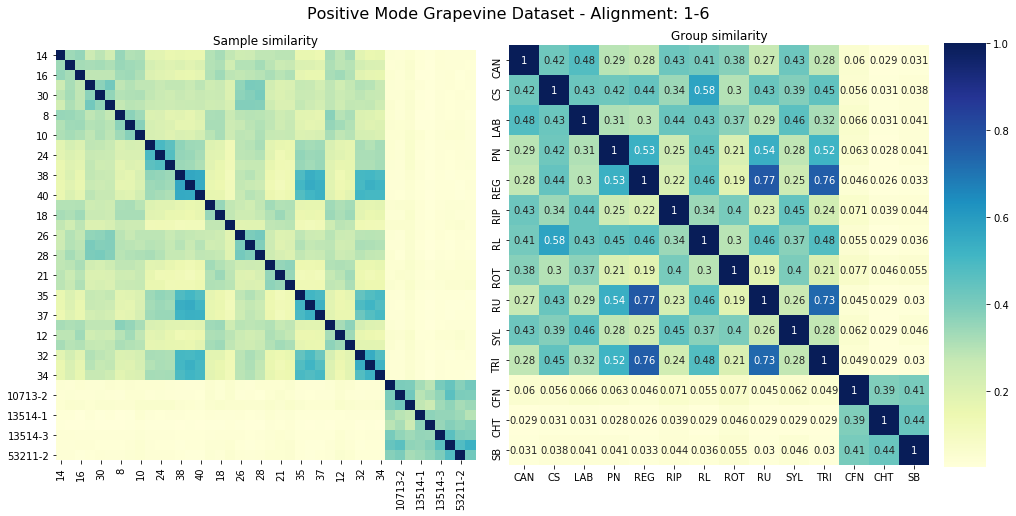

In [17]:
plot_jaccard_sims(aligned_all_pos, 'Positive Mode Grapevine Dataset - Alignment: 1-6')

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [18]:
intensities = aligned_all_neg
neg_01 = treat_neg['binary']

scipy_jdist = dist.pdist(neg_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=sample_names, columns=sample_names)

#sim_neg = mz_similarity(intensities, has_labels=True)
jsim = sim_neg.sample_similarity_jaccard
#jsim.index.name = 'Sample'
#jsim.columns.name = 'Sample'
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

Dendogram from Jaccard distance, Negative mode Grapevine dataset - Alignment: 1-6 (cophenetic = 0.96261)


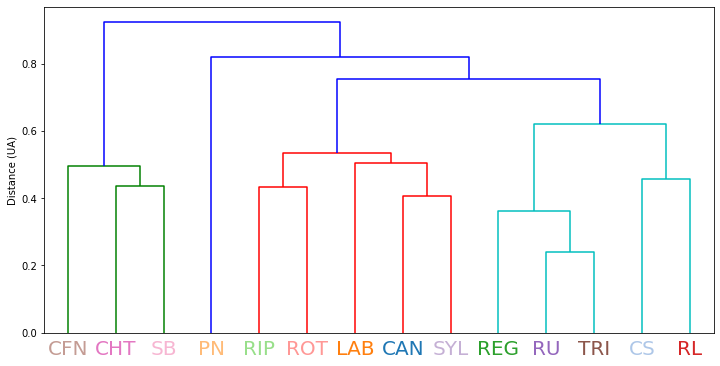

In [19]:
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Negative mode Grapevine dataset - Alignment: 1-6 (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Dendogram from Jaccard distance, Positive mode Grapevine dataset - Alignment: 1-6 (cophenetic = 0.97734)


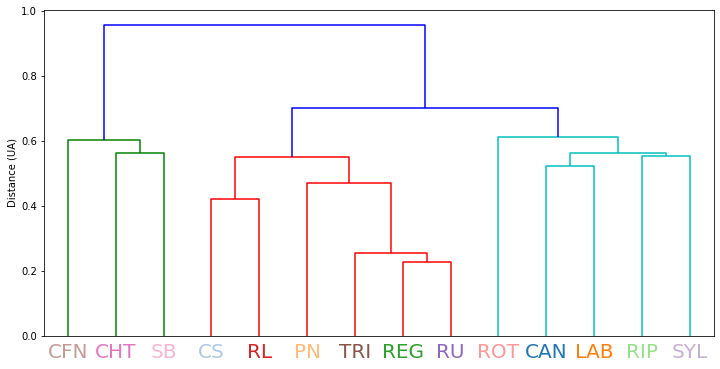

In [20]:
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Positive mode Grapevine dataset - Alignment: 1-6 (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

## Hierarchical Cluster Analysis (agglomerative)


### Non-binary Similarity Analysis

All samples need to have missing value imputation (removing features is optional) with the function NaN_Imputation of scaling.py (replace missing features with half of the minimum intensity of the full dataset).

After that, the rest of the data processing can vary where 3 different processing methods were applied in different combinations:

##### Normalization by a references feature (Norm_feat from scaling.py) - N;
##### Glog transformation/ log2 transformation (glog from scaling.py) - G;
##### Pareto Scaling (ParetoScal from scaling.py) - P.

In [21]:
def plot_dendogram(Z, title=''):
    fig = plt.figure(figsize=(16,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=15, above_threshold_color='b')
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 13)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

### Negative Mode - 1-6 "True" Non Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

Each feature appears at least in 6 of 39 samples. 1_6 in figures.

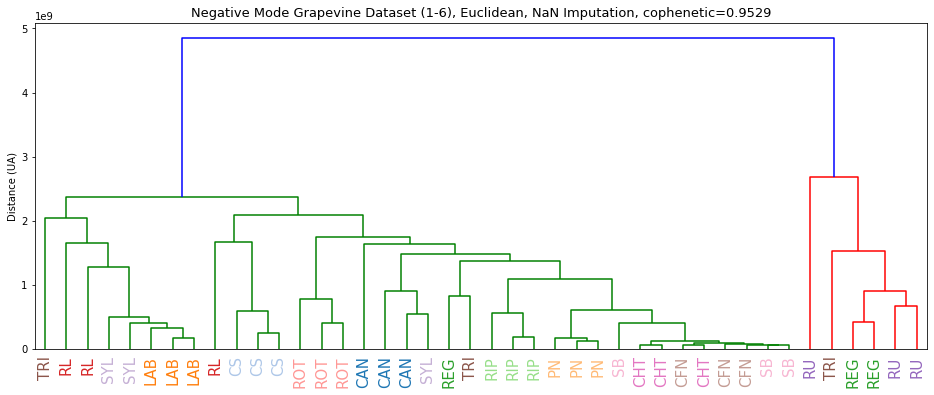

In [22]:
# Missing Value Imputation only
Imp_neg = treat_neg['Ionly']
dist_Imp_neg = dist.pdist(Imp_neg.T, metric = 'euclidean')
Z_Imp_neg = hier.linkage(dist_Imp_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg, dist_Imp_neg)[0]

title = f'Negative Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg, title)

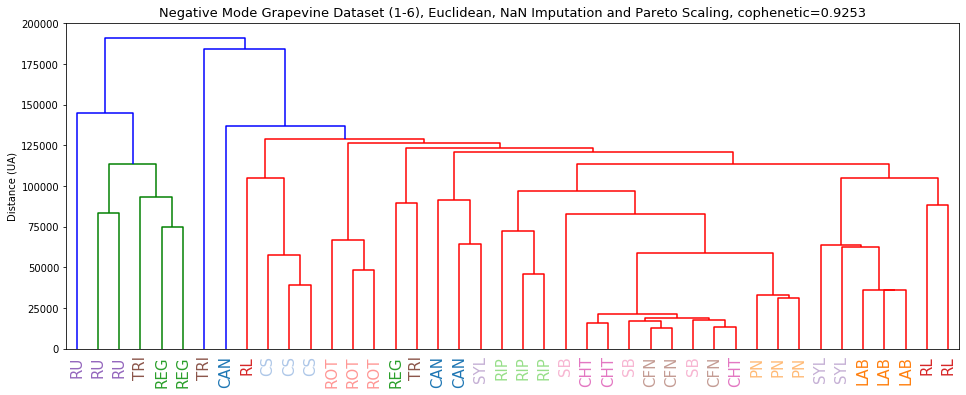

In [23]:
# Imputed and Pareto scaled
P_neg = treat_neg['P']
dist_P_neg = dist.pdist(P_neg.T, metric = 'euclidean')
Z_P_neg = hier.linkage(dist_P_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg, dist_P_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg, title)

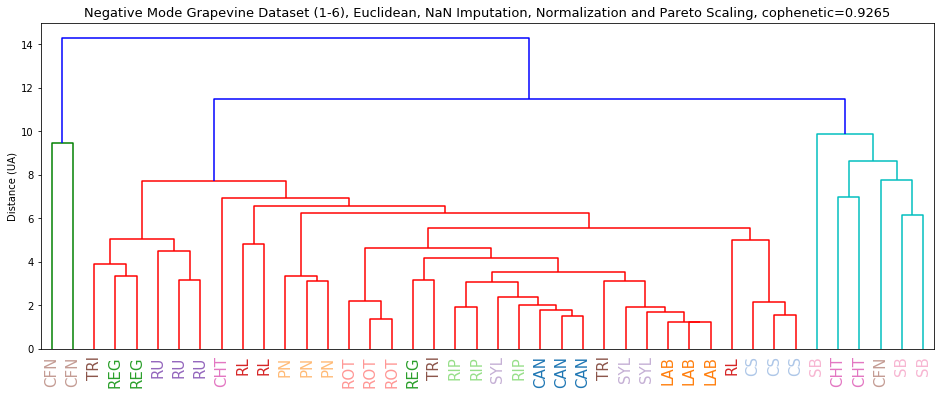

In [24]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_neg = treat_neg['NP']
dist_NP_neg = dist.pdist(NP_neg.T, metric = 'euclidean')
Z_NP_neg = hier.linkage(dist_NP_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg, dist_NP_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg, title)

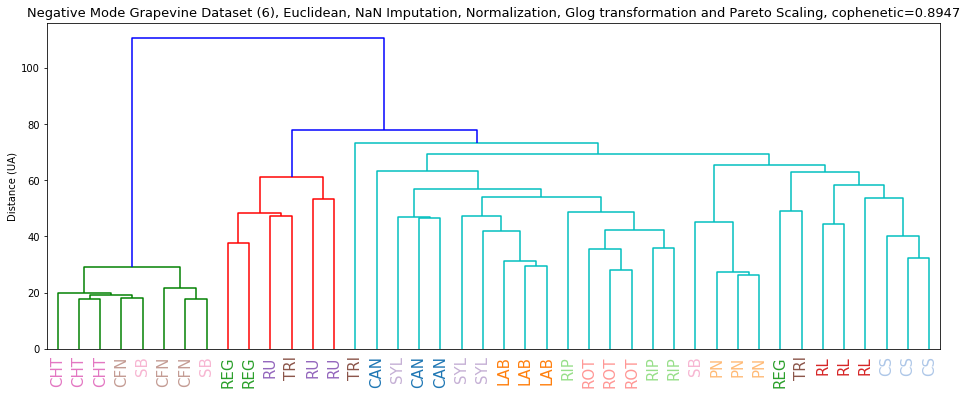

In [25]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_neg = treat_neg['NGP']
dist_NGP_neg = dist.pdist(NGP_neg.T, metric = 'euclidean')
Z_NGP_neg = hier.linkage(dist_NGP_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg, dist_NGP_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (6), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg, title)

#### Binary Similarity Analysis Methods - Example Dendogram

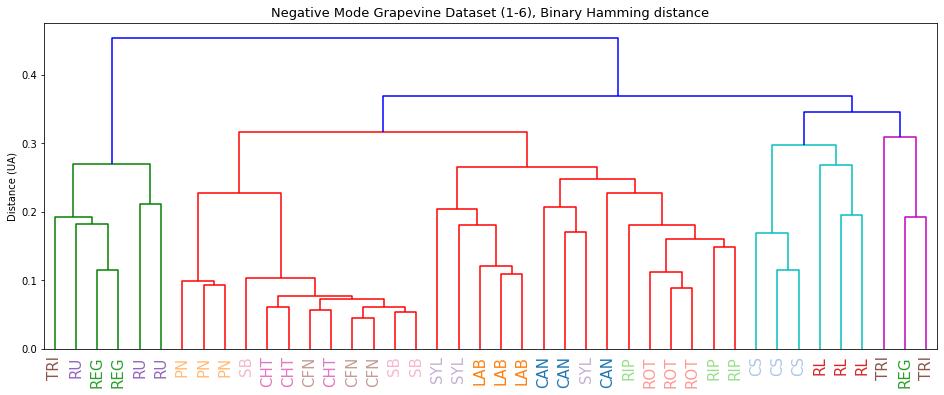

In [26]:
binary = treat_neg['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Negative Mode Grapevine Dataset (1-6), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Greys / Black and White matrixes depicting normal intensity / binary treated dataset (respectively)

Black and White - Binary treated Negative mode Grapevine dataset


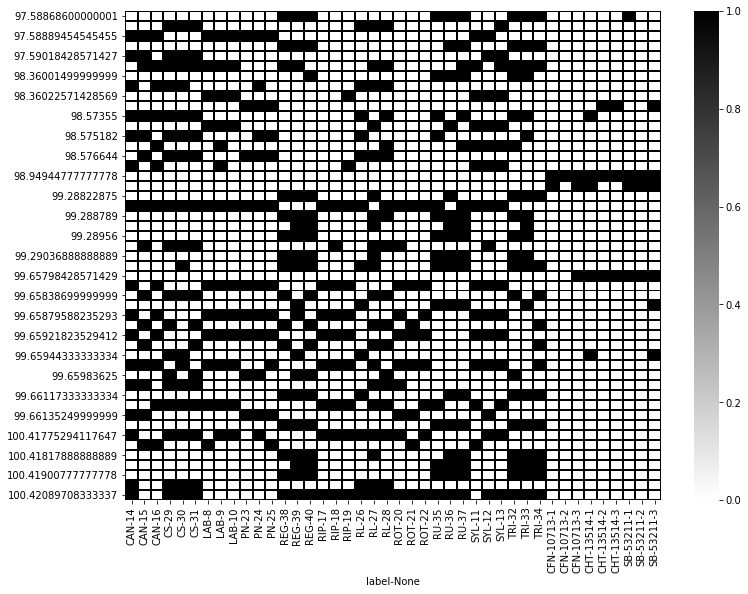

In [27]:
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(treat_neg['binary'].iloc[:50,:], annot=False, ax=ax, cmap = 'gray_r', linewidths = 1, linecolor = 'black')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
print('Black and White - Binary treated Negative mode Grapevine dataset')
plt.show()

Greys - Negative mode Grapevine dataset with Intensity data after NGP treatment


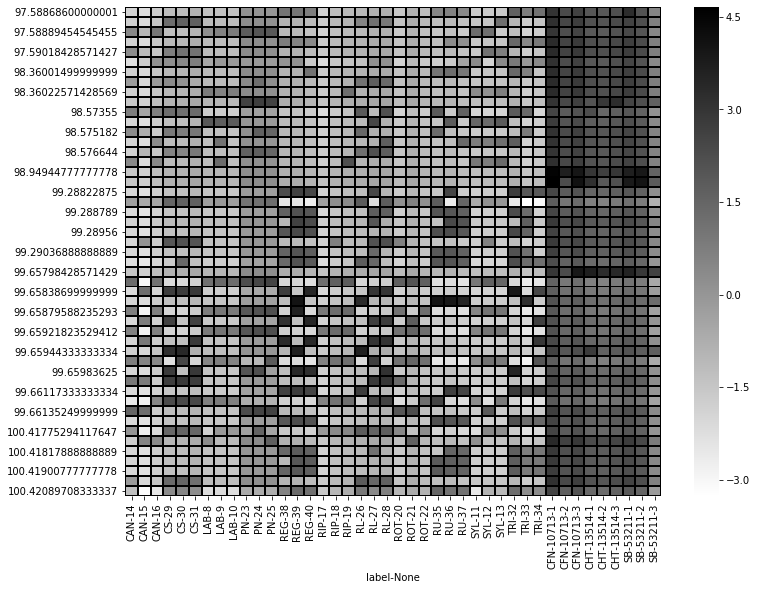

In [28]:
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(NGP_neg.iloc[:50,:], annot=False, ax=ax, cmap = 'gray_r', linewidths = 1, linecolor = 'black')#, yticklabels = Euc_NGP_neg.data.index[:100])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
print('Greys - Negative mode Grapevine dataset with Intensity data after NGP treatment')
plt.show()

### Positive Mode - 1-6 "True" Non Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

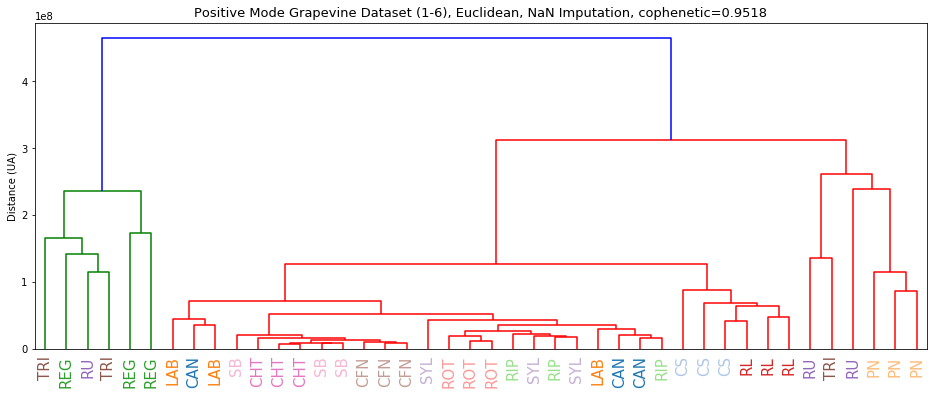

In [29]:
# Missing Value Imputation only
Imp_pos = treat_pos['Ionly']
dist_Imp_pos = dist.pdist(Imp_pos.T, metric = 'euclidean')
Z_Imp_pos = hier.linkage(dist_Imp_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_pos, dist_Imp_pos)[0]

title = f'Positive Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_pos, title)

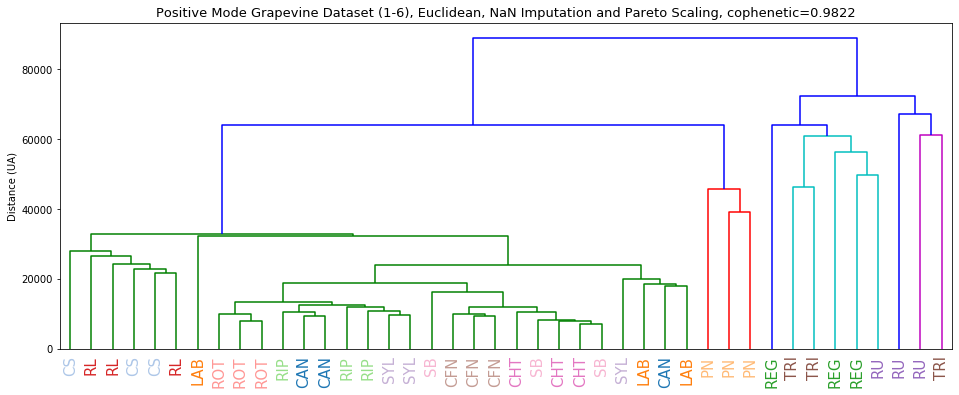

In [30]:
# Imputed and Pareto scaled
P_pos = treat_pos['P']
dist_P_pos = dist.pdist(P_pos.T, metric = 'euclidean')
Z_P_pos = hier.linkage(dist_P_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos, dist_P_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos, title)

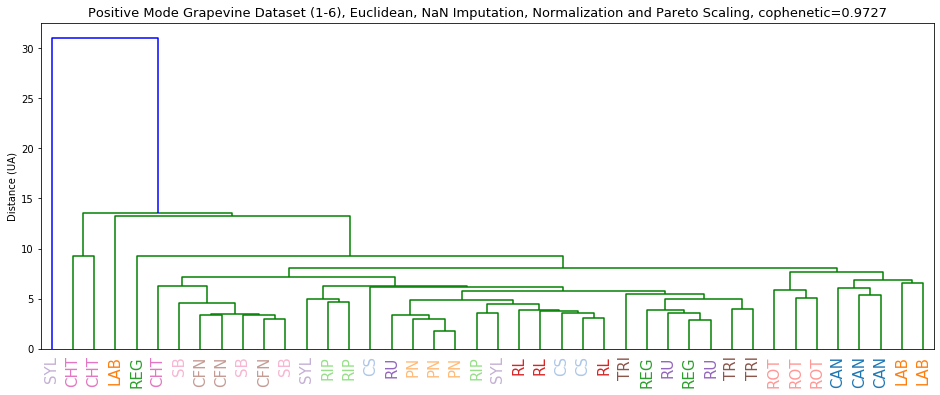

In [31]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_pos = treat_pos['NP']
dist_NP_pos = dist.pdist(NP_pos.T, metric = 'euclidean')
Z_NP_pos = hier.linkage(dist_NP_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos, dist_NP_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos, title)

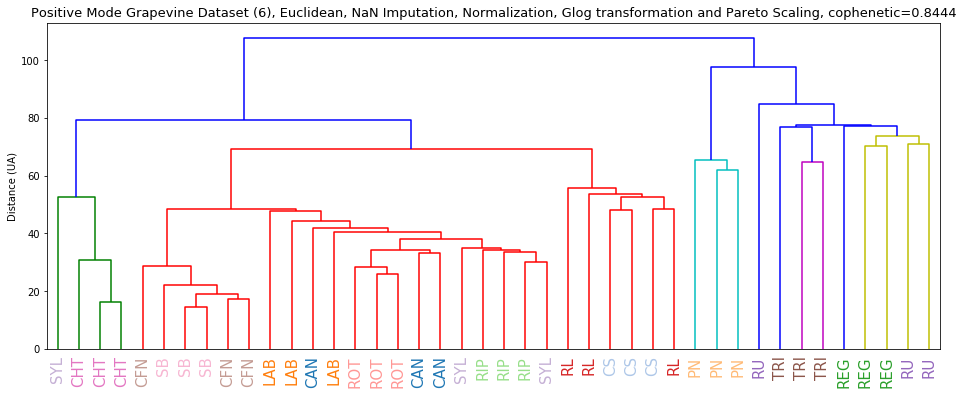

In [32]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_pos = treat_pos['NGP']
dist_NGP_pos = dist.pdist(NGP_pos.T, metric = 'euclidean')
Z_NGP_pos = hier.linkage(dist_NGP_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos, dist_NGP_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (6), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos, title)

#### Binary Similarity Analysis Methods - Example Dendogram

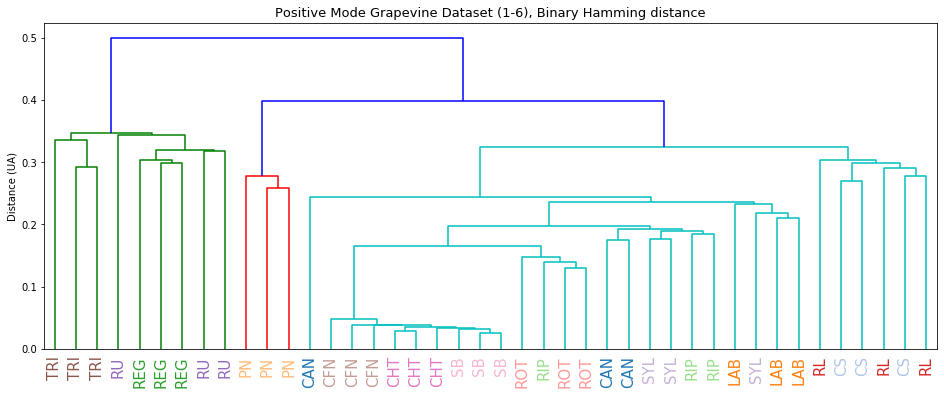

In [33]:
binary = treat_pos['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Positive Mode Grapevine Dataset (1-6), Binary Hamming distance'
plot_dendogram(Zdice, title)

## 2nd Peak Alignment - 1-2 / 1-13

Presented with 2 following the names. Example: treat_neg2.

Same types of processing as before.

### 1-2 alignment - Currently in use

Each feature appears in at least 2 of the 39 samples. Appears as 1_2 in figures (may appear as 1_13).

In [34]:
aligned_all_pos2 = pd.HDFStore('alignments_old.h5').get('all_1ppm_min2_pos')
aligned_all_neg2 = pd.HDFStore('alignments_old.h5').get('all_1ppm_min2_neg')

### 1-13 alignment 

Each feature appears in at least 13 of the 39 samples. Appears as 1_13 in figures (may appear as 1_2).

In [35]:
#aligned_all_pos2 = pd.HDFStore('alignments.h5').get('all_1ppm_min13_pos')
#aligned_all_neg2 = pd.HDFStore('alignments.h5').get('all_1ppm_min13_neg')

#### Performing treatments

In [36]:
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg2, 554.2615) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos2, 556.2771)
print(RefEst_Pos)

(554.26202, 0.0005200000000513683)
(556.27657, 0.0005300000000261207)


In [37]:
# Negative mode dataset
#treat_neg2 = compute_transf(aligned_all_neg2, norm_ref = 554.2620199999996) #6
treat_neg2 = compute_transf(aligned_all_neg2, norm_ref = 554.26202) #2

# Positive mode dataset
#treat_pos2 = compute_transf(aligned_all_pos2, norm_ref = 556.2765711904766) #6
treat_pos2 = compute_transf(aligned_all_pos2, norm_ref = 556.27657) #2

### Negative Mode - 1-2 / 1-13 "True" Non Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

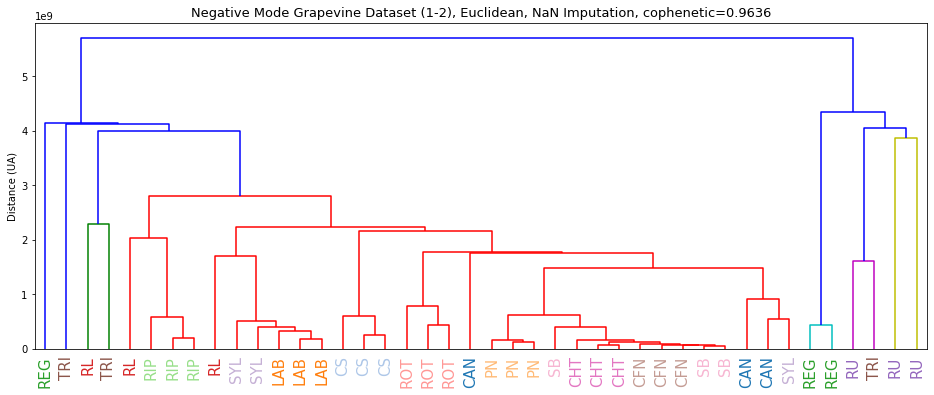

In [38]:
# Missing Value Imputation only
Imp_neg2 = treat_neg2['Ionly']
dist_Imp_neg2 = dist.pdist(Imp_neg2.T, metric = 'euclidean')
Z_Imp_neg2 = hier.linkage(dist_Imp_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg2, dist_Imp_neg2)[0]

title = f'Negative Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg2, title)

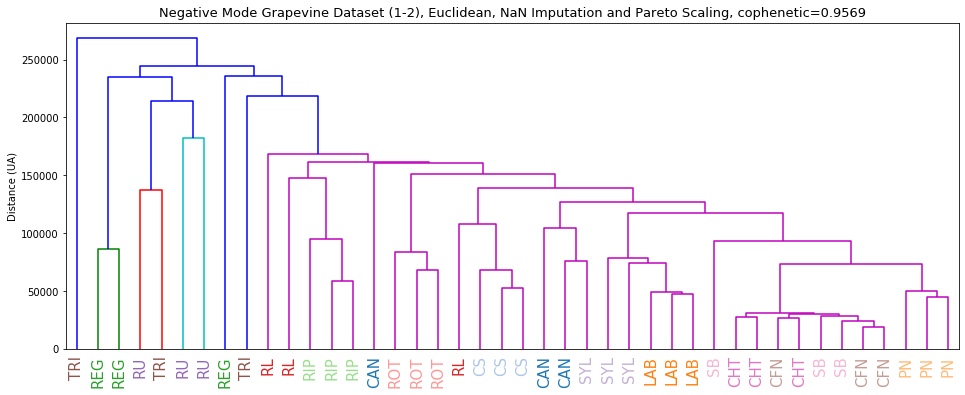

In [39]:
# Imputed and Pareto scaled
P_neg2 = treat_neg2['P']
dist_P_neg2 = dist.pdist(P_neg2.T, metric = 'euclidean')
Z_P_neg2 = hier.linkage(dist_P_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg2, dist_P_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg2, title)

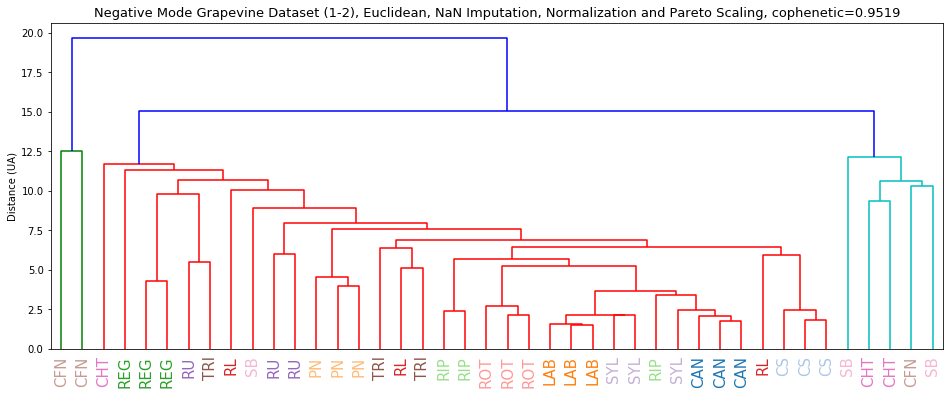

In [40]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_neg2 = treat_neg2['NP']
dist_NP_neg2 = dist.pdist(NP_neg2.T, metric = 'euclidean')
Z_NP_neg2 = hier.linkage(dist_NP_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg2, dist_NP_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg2, title)

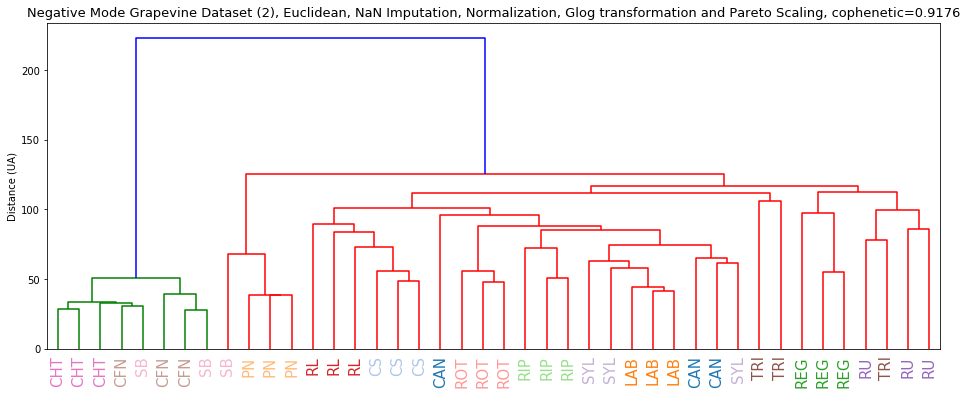

In [41]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_neg2 = treat_neg2['NGP']
dist_NGP_neg2 = dist.pdist(NGP_neg2.T, metric = 'euclidean')
Z_NGP_neg2 = hier.linkage(dist_NGP_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg2, dist_NGP_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (2), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg2, title)

#### Binary Similarity Analysis Methods - Example Dendogram

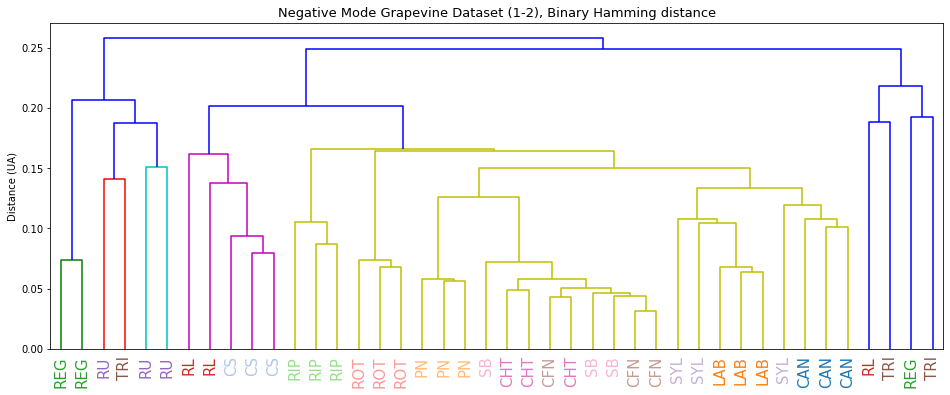

In [42]:
binary = treat_neg2['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Negative Mode Grapevine Dataset (1-2), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Positive Mode - 1-2/1-13 "True" Non Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

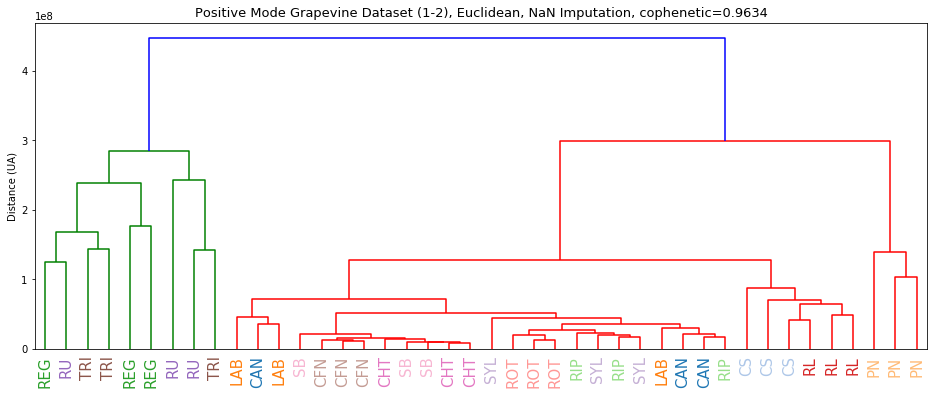

In [43]:
# Missing Value Imputation only
Imp_pos2 = treat_pos2['Ionly']
dist_Imp_pos2 = dist.pdist(Imp_pos2.T, metric = 'euclidean')
Z_Imp_pos2 = hier.linkage(dist_Imp_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_pos2, dist_Imp_pos2)[0]

title = f'Positive Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_pos2, title)

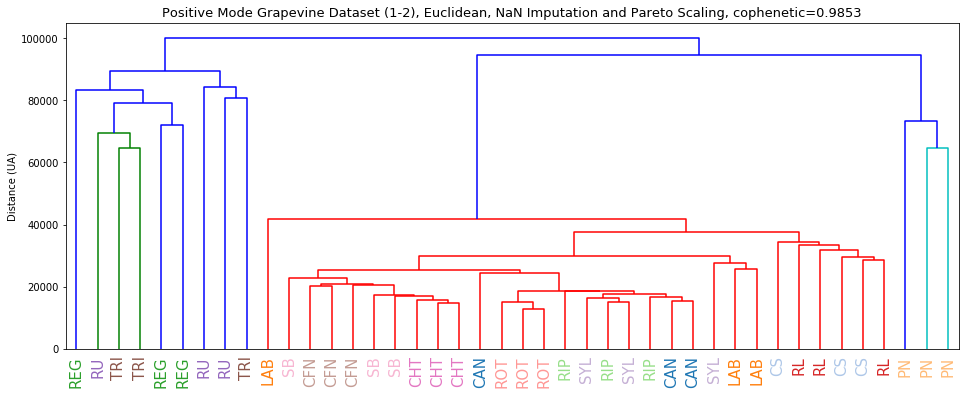

In [44]:
# Imputed and Pareto scaled
P_pos2 = treat_pos2['P']
dist_P_pos2 = dist.pdist(P_pos2.T, metric = 'euclidean')
Z_P_pos2 = hier.linkage(dist_P_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos2, dist_P_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos2, title)

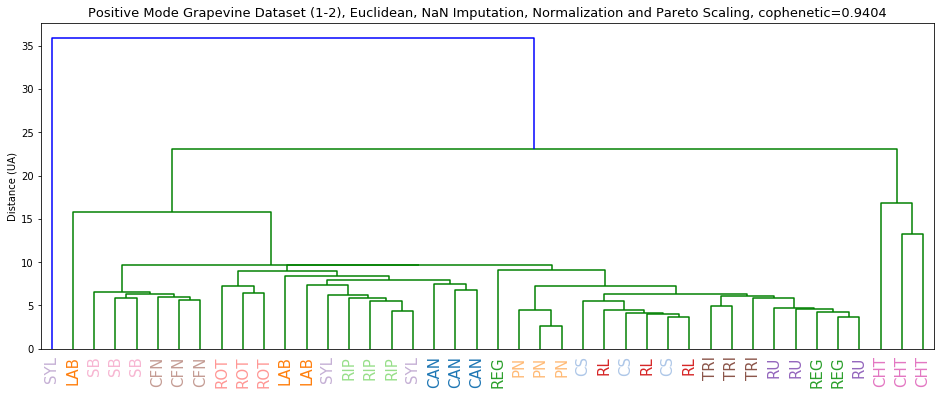

In [45]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_pos2 = treat_pos2['NP']
dist_NP_pos2 = dist.pdist(NP_pos2.T, metric = 'euclidean')
Z_NP_pos2 = hier.linkage(dist_NP_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos2, dist_NP_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (1-2), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos2, title)

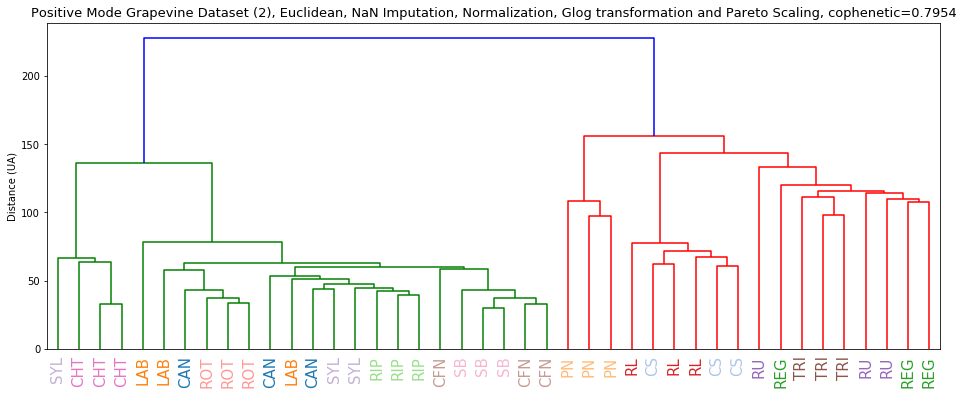

In [46]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_pos2 = treat_pos2['NGP']
dist_NGP_pos2 = dist.pdist(NGP_pos2.T, metric = 'euclidean')
Z_NGP_pos2 = hier.linkage(dist_NGP_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos2, dist_NGP_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (2), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos2, title)

#### Binary Similarity Analysis Methods - Example Dendogram

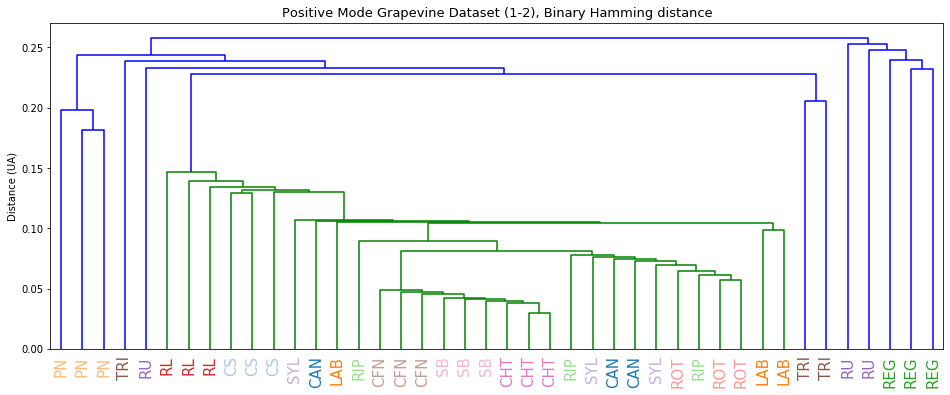

In [47]:
binary = treat_pos2['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Positive Mode Grapevine Dataset (1-2), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Comparing Dendrograms

#### Two methods so far: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

#### Imp/Ionly not used in this comparison

In [48]:
euclidean = (Z_P_neg, Z_NP_neg, Z_NGP_neg, Z_P_pos, Z_NP_pos, Z_NGP_pos,
            Z_P_neg2, Z_NP_neg2, Z_NGP_neg2, Z_P_pos2, Z_NP_pos2, Z_NGP_pos2)
dist_euclidean = (dist_P_neg, dist_NP_neg, dist_NGP_neg, dist_P_pos, dist_NP_pos, dist_NGP_pos,
                 dist_P_neg2, dist_NP_neg2, dist_NGP_neg2, dist_P_pos2, dist_NP_pos2, dist_NGP_pos2)

K_BG = []
S_BG = []
Coph_C = []

for i, (eu, d) in enumerate(zip(euclidean, dist_euclidean)):
    K_BG.append(ma.mergerank(eu)) # Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [49]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples      	Kendall Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.04735795737820598 	 0.008285138863551514
Euc_P_neg-Euc_NGP_neg	 0.22581972859351218 	 9.044016894209275e-35


According to the explanation given in the R package dendextend

In [50]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples      	Spearman Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.03142488967099091 	 0.1924337177261225
Euc_P_neg-Euc_NGP_neg	 0.2437063674519074 	 1.0579837705629392e-24


#### Cophenetic Correlation Coefficient

In [51]:
#Acho que se pode aplicar logo a função np.corrcoef visto os elementos que vêm da função cophenet estão sempre na mesma ordem 
#uns em relação aos outros.

In [52]:
print('Pair of samples      \tPearson Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 -0.03623409499286148 	 0.2882293268106453
Euc_P_neg-Euc_NGP_neg	 0.27113330952984427 	 5.661500424116939e-16


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

Change between number of binary metrics to use

In [53]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
#3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
#binary = ( 'jaccard', 'hamming', 'yule')

In [54]:
aligned_neg = treat_neg['binary']
aligned_pos = treat_pos['binary']
aligned_neg2 = treat_neg2['binary']
aligned_pos2 = treat_pos2['binary']

In [55]:
#Application of all "single" steps needed presented in the examples above with every distance metric.
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_neg.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_neg.T, metric = binary[i]))) #Cophenetic

In [56]:
#Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(aligned_pos.T, metric = binary[i], method='average')) #Z
    K_pos.append(ma.mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0's
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(aligned_pos.T, metric = binary[i]))) #Cophenetic

In [57]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
S = S_BG + S_neg + S_pos

#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
Coph = Coph_C + Coph_neg + Coph_pos

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [58]:
#Column names and row names for the dataframes
#3 binary metrics
#colnames = ['P_neg1_6', 'NP_neg1_6', 'NGP_neg1_6', 'P_pos1_6', 'NP_pos1_6', 'NGP_pos1_6',
#            'P_neg1_2', 'NP_neg1_2', 'NGP_neg1_2', 'P_pos1_2', 'NP_pos1_2', 'NGP_pos1_2', 
#            'hamming_neg1_6', 'jaccard_neg1_6', 'yule_neg1_6',  'hamming_pos1_6', 'jaccard_pos1_6', 'yule_pos1_6']

#9 binary metrics
colnames = ['P_neg1_6', 'NP_neg1_6', 'NGP_neg1_6', 'P_pos1_6', 'NP_pos1_6', 'NGP_pos1_6',
            'P_neg1_2', 'NP_neg1_2', 'NGP_neg1_2', 'P_pos1_2', 'NP_pos1_2', 'NGP_pos1_2',
            'dice_neg1_6', 'hamming_neg1_6', 'jaccard_neg1_6', 'rogerstanimoto_neg1_6', 'sokalmichener_neg1_6', 
            'sokalsneath_neg1_6','yule_neg1_6', 'kulsinski_neg1_6', 'russellrao_neg1_6','dice_pos1_6', 'hamming_pos1_6', 
            'jaccard_pos1_6', 'rogerstanimoto_pos1_6', 'sokalmichener_pos1_6', 'sokalsneath_pos1_6', 'yule_pos1_6', 
            'kulsinski_pos1_6', 'russellrao_pos1_6']

In [59]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [60]:
#Calculation of correlation coefficient for each method

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,12:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:12], line, df.iloc[12:]])
    prep = pd.concat([prep.iloc[:,:12], lineV.T, prep.iloc[:,12:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.


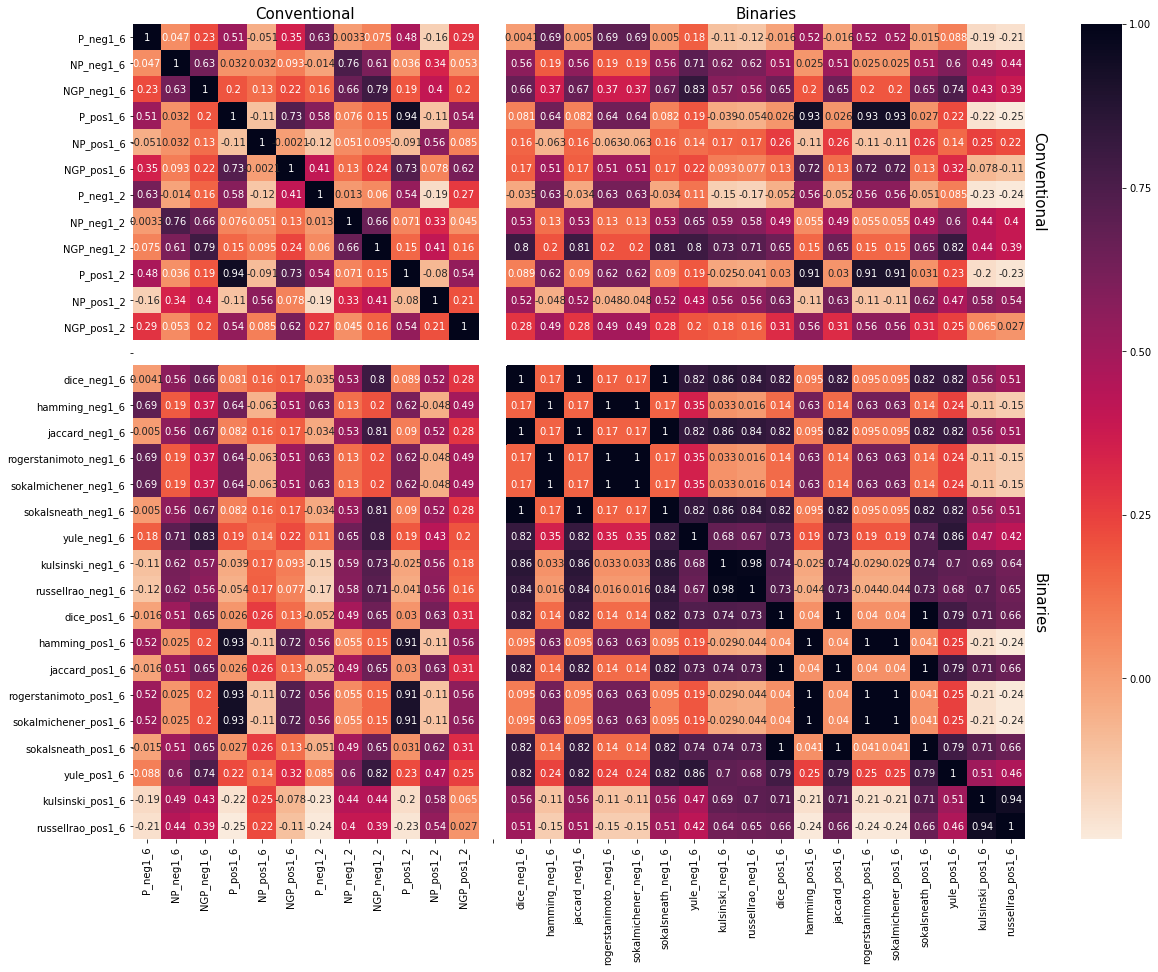

In [61]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

In [62]:
Kendall = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg1-6', 'pos1-6', 'neg1-2', 
                                                                                                'pos1-2', 'neg+pos'))

for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Kendall.iloc[r,j] = df_KI.iloc[13+r,j*3+2]#sum(df_KI.iloc[13+r,j*3:j*3+3])
        elif j in [1,3]:
            Kendall.iloc[r,j] = df_KI.iloc[22+r,j*3+2]#sum(df_KI.iloc[22+r,j*3:j*3+3])
        else:
            Kendall.iloc[r,j] = sum(Kendall.iloc[r,0:4])

Kendall

neg1-6    pos1-6    neg1-2    pos1-2   neg+pos
dice            0.664255  0.133651  0.803653  0.311318  1.912878
hamming         0.366428  0.724012  0.203739  0.556440  1.850620
jaccard         0.665681  0.133630  0.805061  0.311296  1.915668
rogerstanimoto  0.366448  0.724012  0.203759  0.556440  1.850660
sokalmichener   0.366448  0.724012  0.203759  0.556440  1.850660
sokalsneath     0.665681  0.133045  0.805061  0.310515  1.914302
yule            0.833373  0.316757  0.799171  0.253490  2.202791
kulsinski       0.574033 -0.078300  0.729233  0.065161  1.290126
russellrao      0.558871 -0.109553  0.713010  0.027106  1.189433

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.


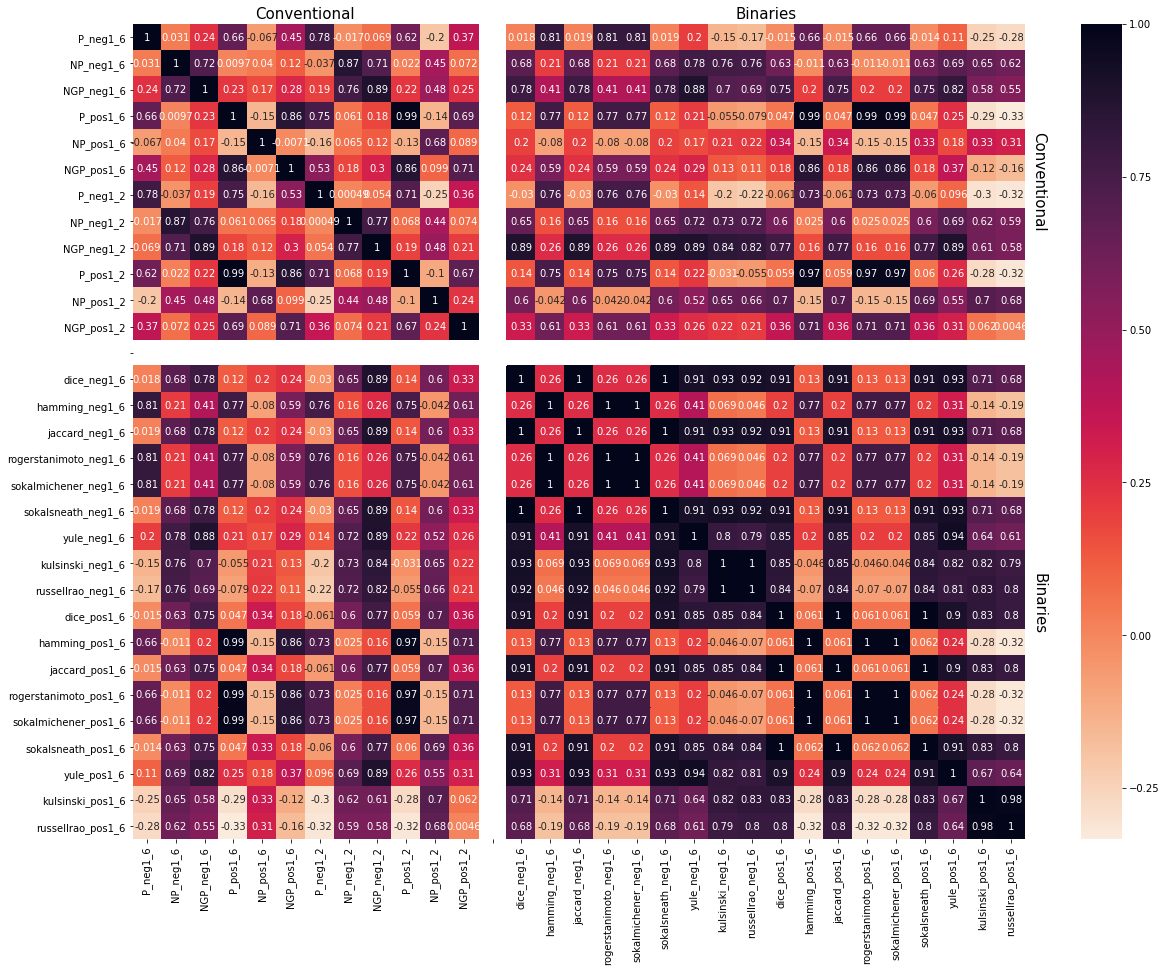

In [63]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.


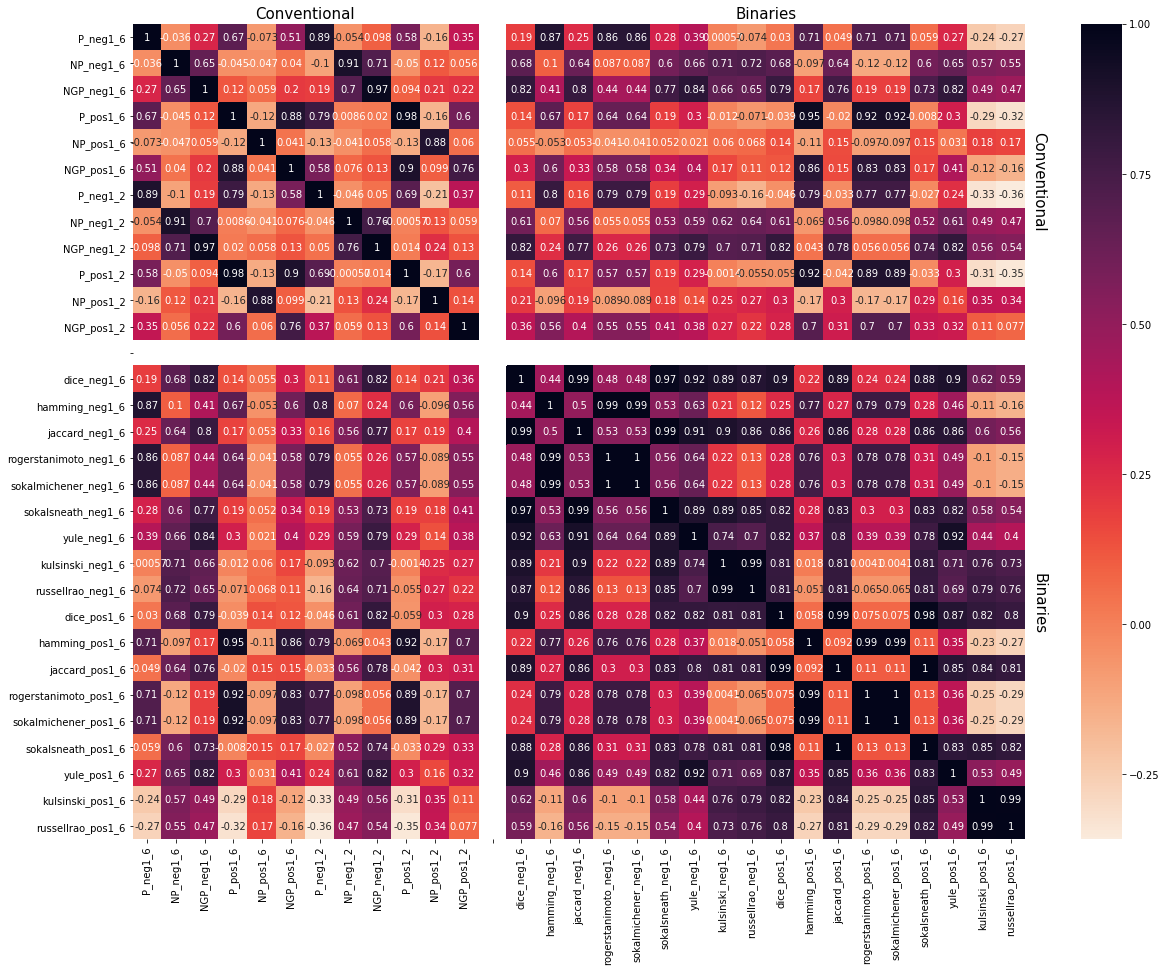

In [64]:
f, ax = plt.subplots(figsize=(20, 15))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

In [65]:
Cophenetic = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg1-6', 'pos1-6', 'neg1-2', 
                                                                                                'pos1-2','neg+pos'))
for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Cophenetic.iloc[r,j] = df_CI.iloc[13+r,j*3+2]#sum(df_CI.iloc[13+r,j*3:j*3+3])
        elif j in [1,3]:
            Cophenetic.iloc[r,j] = df_CI.iloc[22+r,j*3+2]#sum(df_CI.iloc[22+r,j*3:j*3+3])
        else:
            Cophenetic.iloc[r,j] = sum(Cophenetic.iloc[r,0:4])
Cophenetic

neg1-6    pos1-6    neg1-2    pos1-2   neg+pos
dice            0.820021  0.123896  0.815323  0.278780  2.038020
hamming         0.414682  0.855731  0.236012  0.696943  2.203368
jaccard         0.801111  0.151118  0.774947  0.314929  2.042105
rogerstanimoto  0.440599  0.831645  0.262923  0.697820  2.232987
sokalmichener   0.440599  0.831645  0.262923  0.697820  2.232987
sokalsneath     0.771021  0.166595  0.729840  0.333847  2.001303
yule            0.844782  0.411552  0.788586  0.315839  2.360759
kulsinski       0.660452 -0.115963  0.697500  0.107499  1.349488
russellrao      0.645708 -0.158702  0.705533  0.077071  1.269610

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: neg_peakalignment1, pos_peakalignment1, neg_peakalignment2, pos_peakalignment2, neg_binary, pos_binary

In [66]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(4):
    label_colors2[colnames[3*i]] = col_lbl2[i]
    label_colors2[colnames[3*i+1]] = col_lbl2[i]
    label_colors2[colnames[3*i+2]] = col_lbl2[i]
for i in range(9):
    label_colors2[colnames[12+i]] = col_lbl2[4]
    label_colors2[colnames[21+i]] = col_lbl2[5]

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.


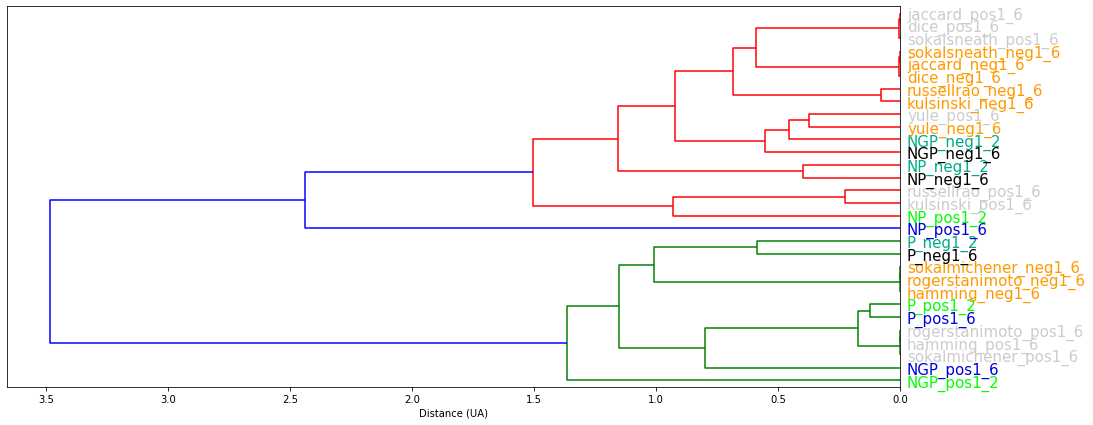

In [67]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.')
Z_K = hier.linkage(correlations['K'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.


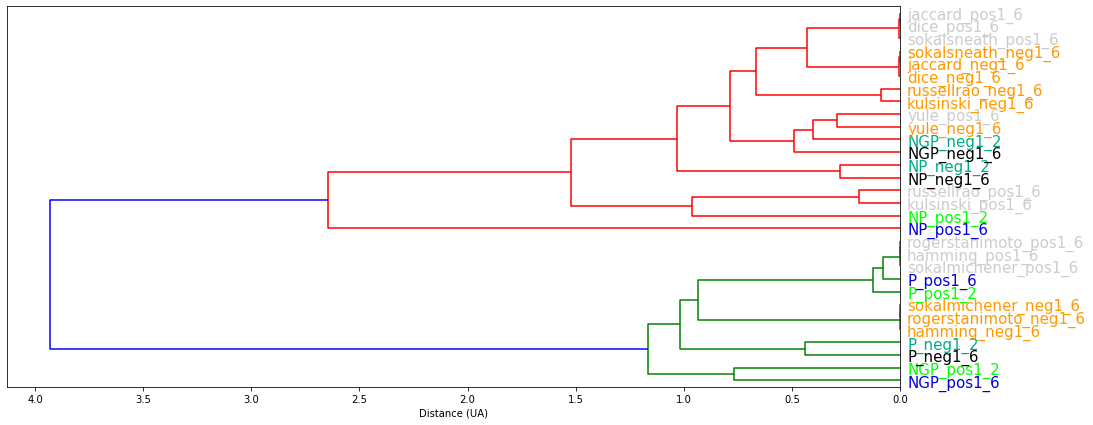

In [68]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.')
Z_S = hier.linkage(correlations['S'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.


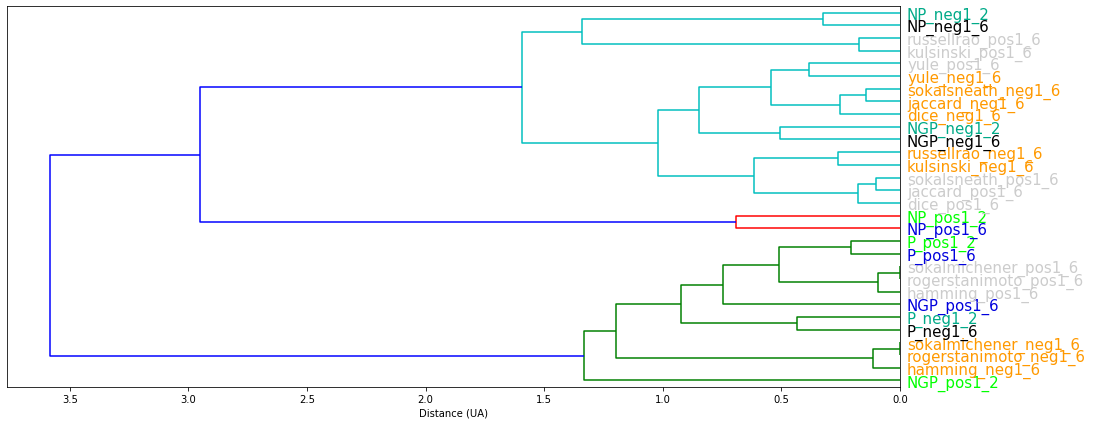

In [69]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('1_2 - Peak alignment requiring that a feature appears at least in 2 samples of all samples.')
Z_C = hier.linkage(correlations['C'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [70]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [71]:
disc_average = np.zeros((1,30))
disc_median = np.zeros((1,30))
disc_correct = np.zeros((1,30))
for i in range(len(Z)):
    data = aligned_all_neg
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,12:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)

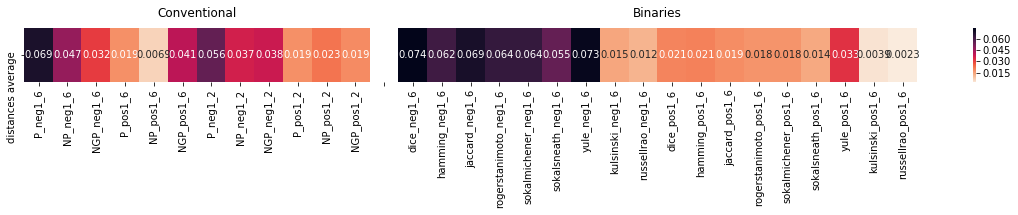

In [72]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(6,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

In [73]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

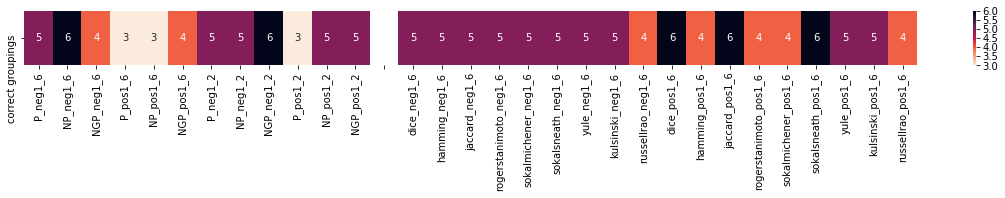

In [74]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### 1-2 (1-13) binaries discrimination distance

In [75]:
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_neg2.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_neg2.T, metric = binary[i]))) #Cophenetic

#Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(aligned_pos2.T, metric = binary[i], method='average')) #Z
    K_pos.append(ma.mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0's
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(aligned_pos2.T, metric = binary[i]))) #Cophenetic

In [76]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [77]:
colnames_ex = ['P_neg1_6', 'NP_neg1_6', 'NGP_neg1_6', 'P_pos1_6', 'NP_pos1_6', 'NGP_pos1_6',
            'P_neg1_2', 'NP_neg1_2', 'NGP_neg1_2', 'P_pos1_2', 'NP_pos1_2', 'NGP_pos1_2',
            'dice_neg1_2', 'hamming_neg1_2', 'jaccard_neg1_2', 'rogerstanimoto_neg1_2', 'sokalmichener_neg1_2', 
            'sokalsneath_neg1_2','yule_neg1_2', 'kulsinski_neg1_2', 'russellrao_neg1_2', 'dice_pos1_2', 'hamming_pos1_2', 
            'jaccard_pos1_2', 'rogerstanimoto_pos1_2', 'sokalmichener_pos1_2', 'sokalsneath_pos1_2', 'yule_pos1_2', 
            'kulsinski_pos1_2', 'russellrao_pos1_2']

In [78]:
disc_average = np.zeros((1,30))
disc_median = np.zeros((1,30))
disc_correct = np.zeros((1,30))
for i in range(len(Z)):
    discrim = ma.dist_discrim(aligned_all_neg, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.dist_discrim(aligned_all_neg, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames_ex)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames_ex)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames_ex)

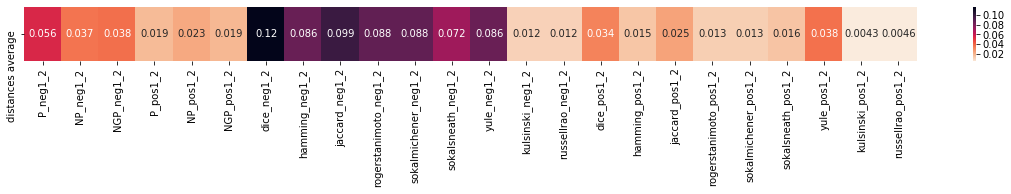

In [79]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average.iloc[:,6:], annot=True, ax=ax, cmap = sns.cm.rocket_r)

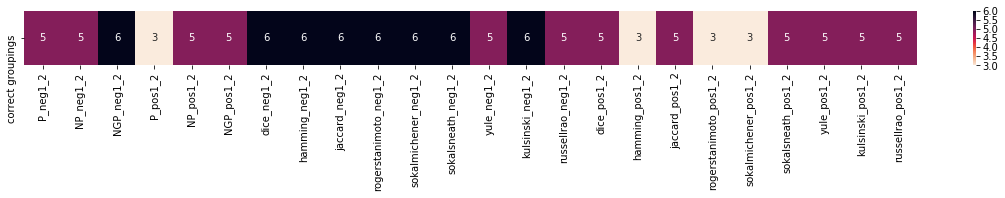

In [80]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct.iloc[:,6:], annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [81]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### Extra binary measures of peak alignment 2: 1-2/1-13

In [82]:
sim_pos2 = mz_similarity(aligned_all_pos2, has_labels = True)
sim_neg2 = mz_similarity(aligned_all_neg2, has_labels = True)

Sample HC, NEGATIVE mode, Peak Alignment: 1-2


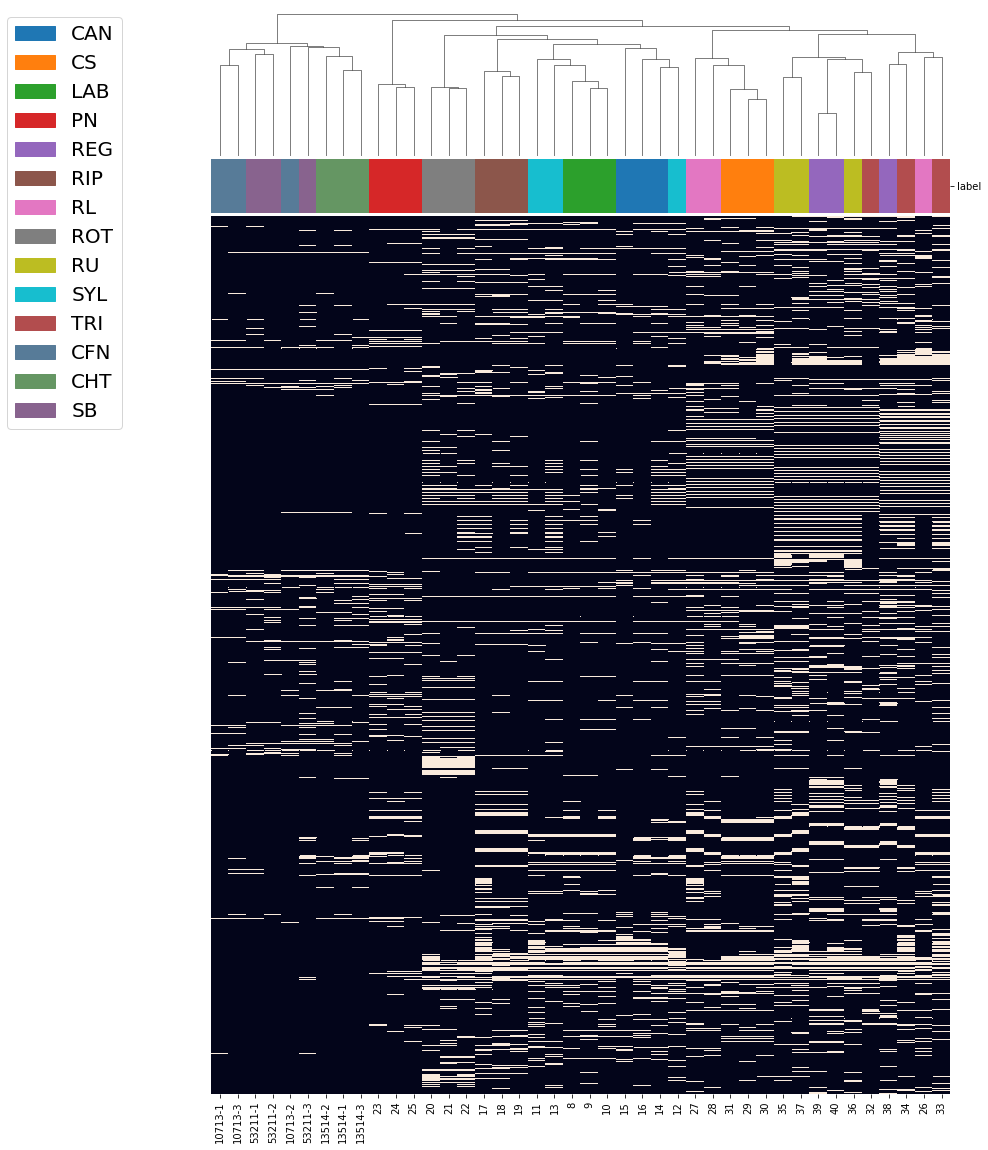

In [83]:
print('Sample HC, NEGATIVE mode, Peak Alignment: 1-2')
g = clustermap_peak_list(aligned_all_neg2)

Sample HC, POSITIVE mode, Peak Alignment: 1-2


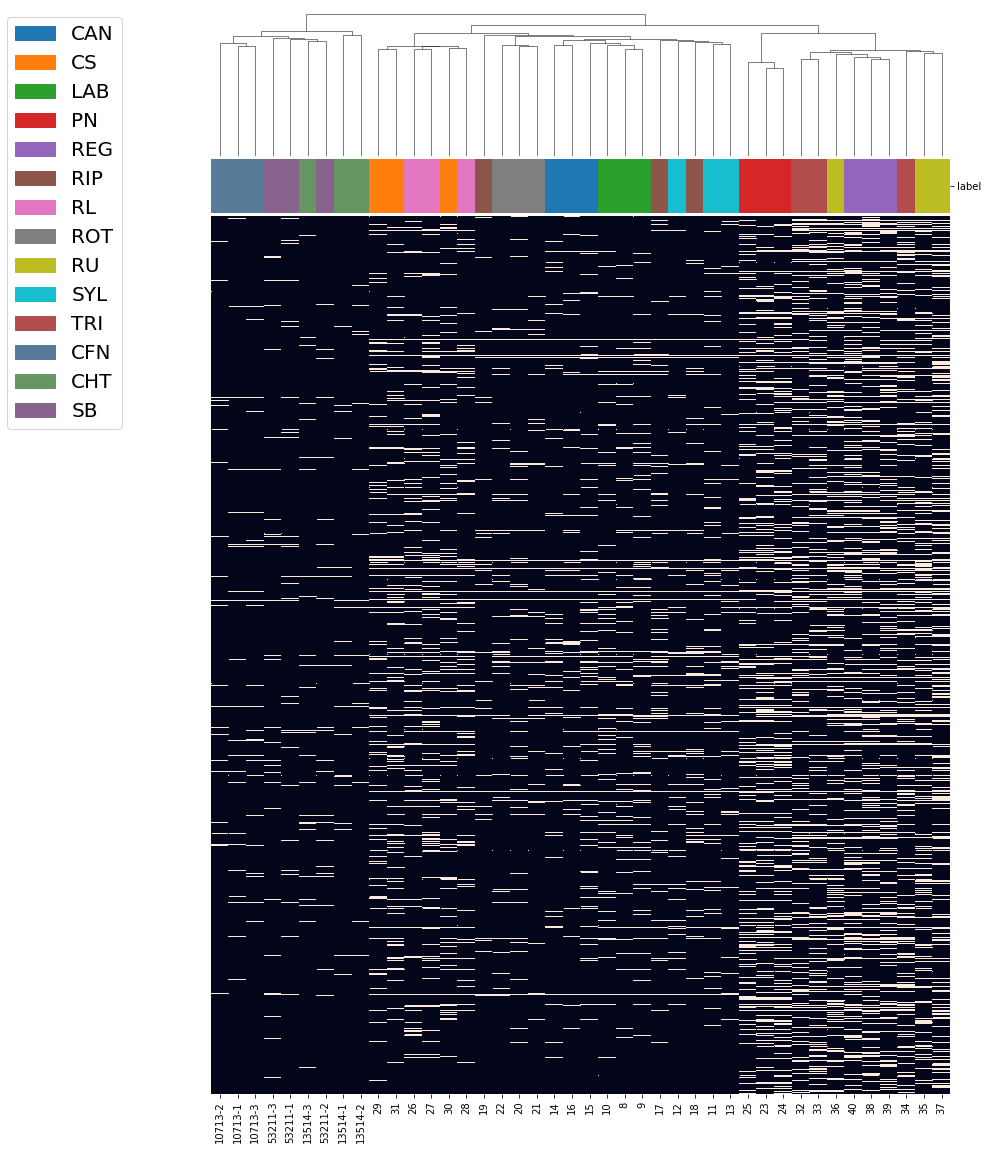

In [84]:
print('Sample HC, POSITIVE mode, Peak Alignment: 1-2')
g = clustermap_peak_list(aligned_all_pos2)

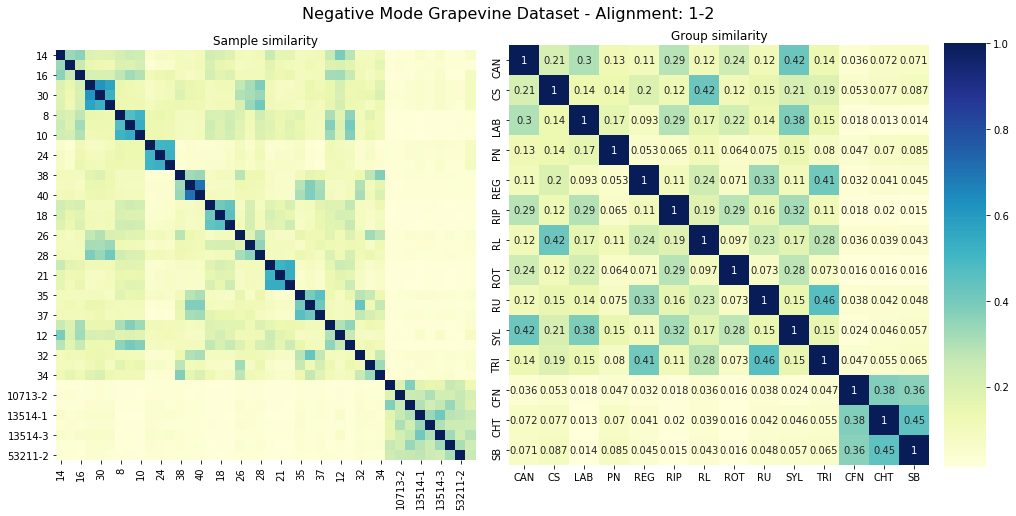

In [85]:
plot_jaccard_sims(aligned_all_neg2, 'Negative Mode Grapevine Dataset - Alignment: 1-2')

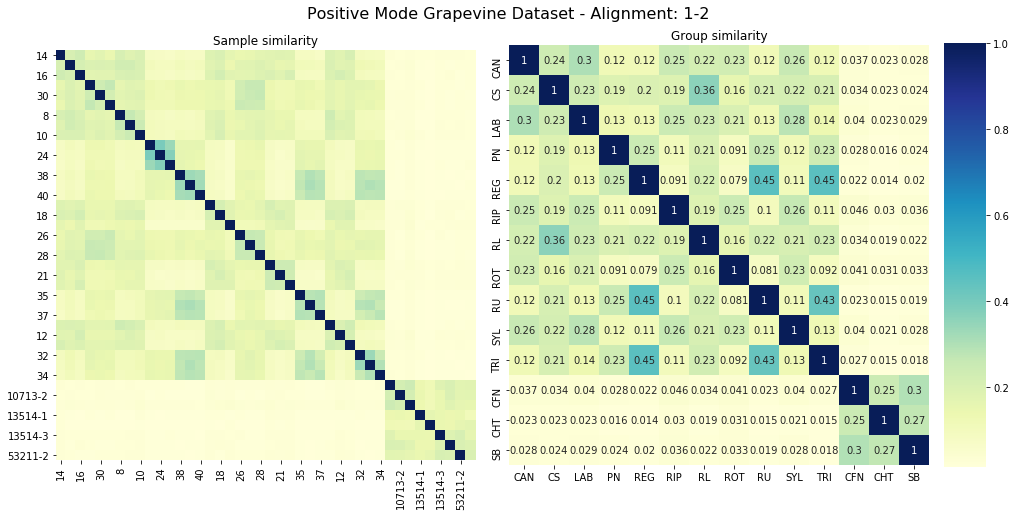

In [86]:
plot_jaccard_sims(aligned_all_pos2, 'Positive Mode Grapevine Dataset - Alignment: 1-2')

### K-means clustering

In [87]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [88]:
Kmean = skclust.KMeans(n_clusters=14)

In [89]:
a = Kmean.fit(NGP_neg.T)

In [90]:
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{11: ['CAN', 'CAN', 'SYL'],
 6: ['CAN'],
 4: ['CS', 'CS', 'CS'],
 8: ['LAB', 'LAB', 'LAB', 'SYL', 'SYL'],
 2: ['PN', 'PN', 'PN', 'SB'],
 7: ['REG', 'TRI'],
 3: ['REG', 'REG', 'RU', 'TRI'],
 1: ['RIP', 'RIP', 'RIP'],
 12: ['RL', 'RL'],
 13: ['RL'],
 10: ['ROT', 'ROT', 'ROT'],
 9: ['RU', 'RU'],
 5: ['TRI'],
 0: ['CFN', 'CFN', 'CFN', 'CHT', 'CHT', 'CHT', 'SB', 'SB']}

Adjusted Rand Index

In [91]:
from sklearn.metrics import adjusted_rand_score
a.labels_
NGP_neg.cdl.labels
adjusted_rand_score(NGP_neg.cdl.labels,a.labels_)

0.47346740974073176

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the Kmeans_discrim function from multianalysis to calculate discrimination distance.

In [92]:
colnames2 = ['P_neg1_6', 'NP_neg1_6', 'NGP_neg1_6', 'P_pos1_6', 'NP_pos1_6', 'NGP_pos1_6',
             'P_neg1_2', 'NP_neg1_2', 'NGP_neg1_2', 'P_pos1_2', 'NP_pos1_2', 'NGP_pos1_2',
             'binary_neg1_6', 'binary_pos1_6','binary_neg1_2', 'binary_pos1_2']

In [93]:
Data = (P_neg, NP_neg, NGP_neg, P_pos, NP_pos, NGP_pos,
        P_neg2, NP_neg2, NGP_neg2, P_pos2, NP_pos2, NGP_pos2, 
        aligned_neg, aligned_pos, aligned_neg2, aligned_pos2)

In [94]:
disc_average = np.zeros((1,16))
disc_median = np.zeros((1,16))
disc_correct = np.zeros((1,16))
rand_index = np.zeros((1,16))

for i in range(len(Data)):
    discrim = ma.Kmeans_discrim(Data[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.Kmeans_discrim(Data[i], method = 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    
    Kmean = skclust.KMeans(n_clusters=14)
    a = Kmean.fit(Data[i].T)
    rand_index[0,i] = adjusted_rand_score(Data[i].cdl.labels,a.labels_)

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames2)

rand_index = pd.DataFrame(rand_index, index = ['correct groupings'], columns = colnames2)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['distances average']).T, disc_average.iloc[:,12:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['distances median']).T, disc_median.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)
rand_index = pd.concat([rand_index.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, rand_index.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['correct groupings']).T, rand_index.iloc[:,12:]], axis = 1)

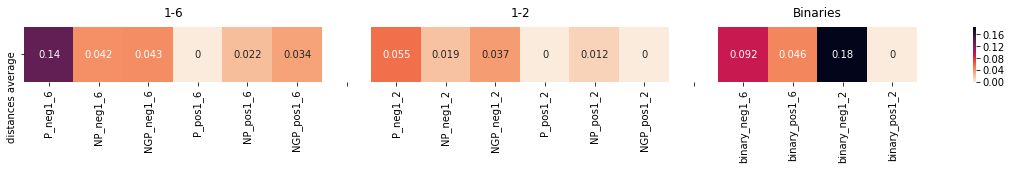

In [95]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'1-6', fontsize  = 12, horizontalalignment='center')
plt.text(10,-0.2,'1-2', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

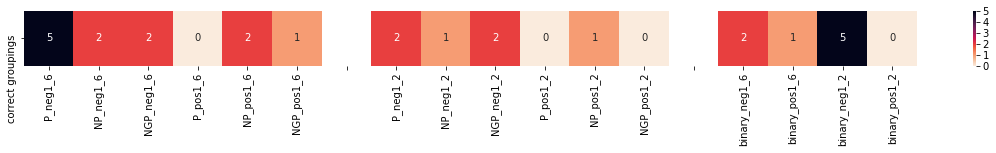

In [96]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [97]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

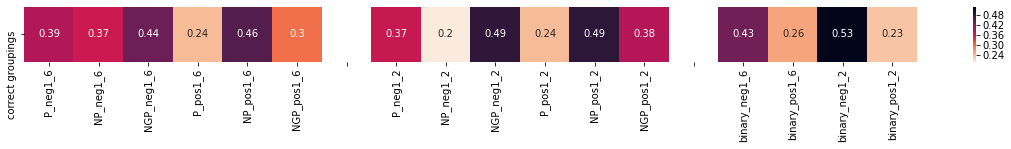

In [98]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(rand_index, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### RandomForests Attempts - 3-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

### Test number of trees needed for convergence for N, NP, NGP and binary data (both alignments)

Grid search of number of trees from 10 to 1000 for the random forests. See where the cross-validation score stops improving for each one.

#### Takes  considerable time

In [99]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,600,10)}

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [100]:
# Centralize data information in a dictionary
datasets = {}

datasets['I_neg'] = treat_neg['Ionly']
datasets['P_neg'] = treat_neg['P']
datasets['NP_neg'] = treat_neg['NP']
datasets['NGP_neg'] = treat_neg['NGP']
datasets['bin_neg'] = treat_neg['binary']

datasets['I_pos'] = treat_pos['Ionly']
datasets['P_pos'] = treat_pos['P']
datasets['NP_pos'] = treat_pos['NP']
datasets['NGP_pos'] = treat_pos['NGP']
datasets['bin_pos'] = treat_pos['binary']

datasets['I_neg2'] = treat_neg2['Ionly']
datasets['P_neg2'] = treat_neg2['P']
datasets['NP_neg2'] = treat_neg2['NP']
datasets['NGP_neg2'] = treat_neg2['NGP']
datasets['bin_neg2'] = treat_neg2['binary']

datasets['I_pos2'] = treat_pos2['Ionly']
datasets['P_pos2'] = treat_pos2['P']
datasets['NP_pos2'] = treat_pos2['NP']
datasets['NGP_pos2'] = treat_pos2['NGP']
datasets['bin_pos2'] = treat_pos2['binary']

In [101]:
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting I_neg ... Done!
Fitting P_neg ... Done!
Fitting NP_neg ... Done!
Fitting NGP_neg ... Done!
Fitting bin_neg ... Done!
Fitting I_pos ... Done!
Fitting P_pos ... Done!
Fitting NP_pos ... Done!
Fitting NGP_pos ... Done!
Fitting bin_pos ... Done!
Fitting I_neg2 ... Done!
Fitting P_neg2 ... Done!
Fitting NP_neg2 ... Done!
Fitting NGP_neg2 ... Done!
Fitting bin_neg2 ... Done!
Fitting I_pos2 ... Done!
Fitting P_pos2 ... Done!
Fitting NP_pos2 ... Done!
Fitting NGP_pos2 ... Done!
Fitting bin_pos2 ... Done!


Performance based on number of trees - Alignment: 1-6, Negative Mode


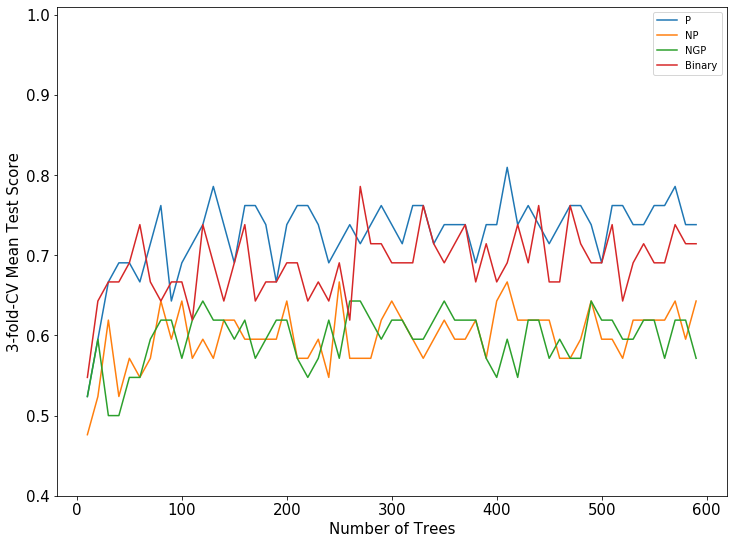

In [102]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(1,5):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-6, Negative Mode')

Performance based on number of trees - Alignment: 1-6, Positive Mode


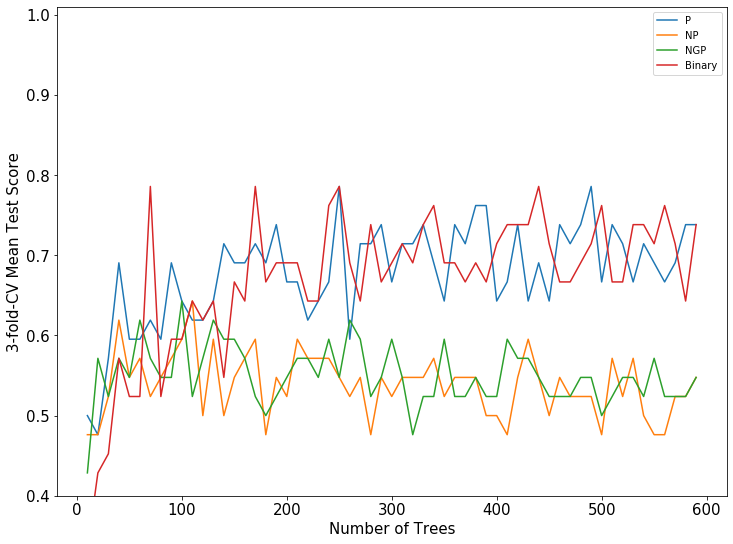

In [103]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(6,10):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-6, Positive Mode')

Performance based on number of trees - Alignment: 1-2, Negative Mode


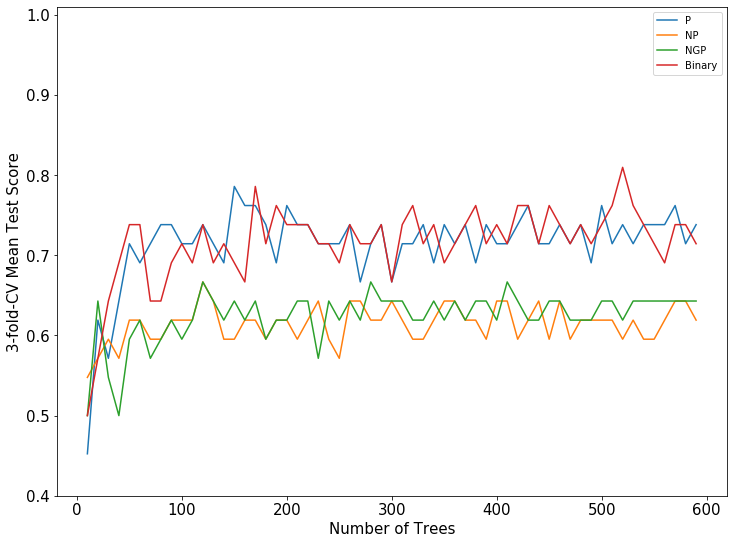

In [104]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(11,15):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-2, Negative Mode')

Performance based on number of trees - Alignment: 1-2, Positive Mode


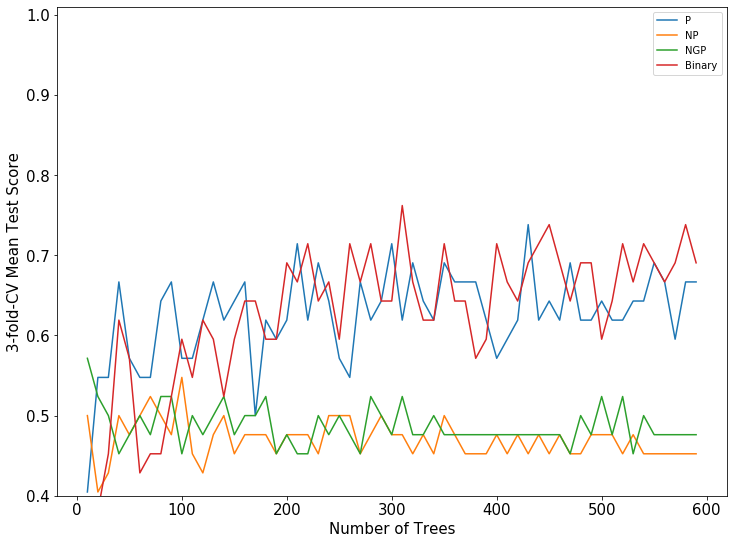

In [105]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(16,20):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-2, Positive Mode')

### Performance of N, NP and NGP data treatments (alignments 1-6 and 1-2 (1-13))

See performance of all 3 treatments and absence of them in non-binary data to see which performs the best using method nº1 (simple application of random forests), see below.

In [106]:
Teste = {}
Teste_std = {}
Teste_feat = {}

In [107]:
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data) #, iter_num = 100)
    Teste[name] = rf
    Teste_std[name] = np.std(rf)
    Teste_feat[name] = imp_features
    print(f'done')    

Fitting random forest for I_neg ...done
Fitting random forest for P_neg ...done
Fitting random forest for NP_neg ...done
Fitting random forest for NGP_neg ...done
Fitting random forest for bin_neg ...done
Fitting random forest for I_pos ...done
Fitting random forest for P_pos ...done
Fitting random forest for NP_pos ...done
Fitting random forest for NGP_pos ...done
Fitting random forest for bin_pos ...done
Fitting random forest for I_neg2 ...done
Fitting random forest for P_neg2 ...done
Fitting random forest for NP_neg2 ...done
Fitting random forest for NGP_neg2 ...done
Fitting random forest for bin_neg2 ...done
Fitting random forest for I_pos2 ...done
Fitting random forest for P_pos2 ...done
Fitting random forest for NP_pos2 ...done
Fitting random forest for NGP_pos2 ...done
Fitting random forest for bin_pos2 ...done


Accuracy based on the dataset


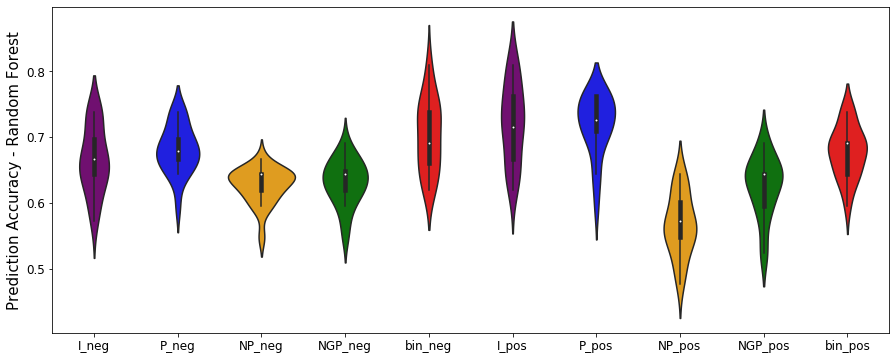

In [108]:
f, ax = plt.subplots(figsize=(15,6))
data = pd.DataFrame.from_dict(Teste)
colors = ['purple','blue','orange','green','red']
sns.violinplot( data = data.iloc[:,:10], palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

Accuracy based on the dataset


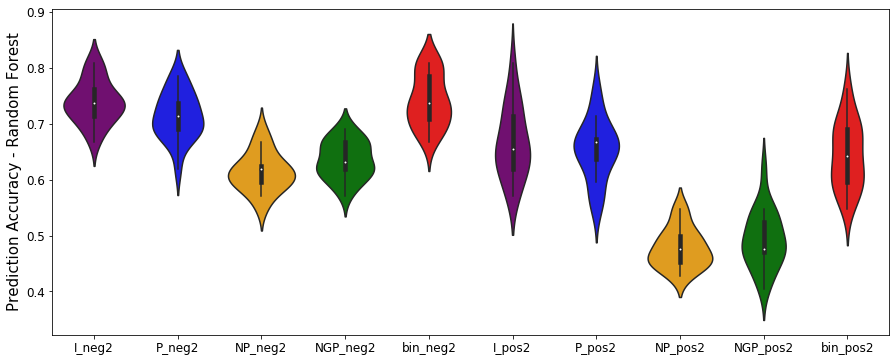

In [109]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['purple','blue','orange','green','red']
sns.violinplot( data = data.iloc[:,10:], palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

In [110]:
#Here is median
Teste_A = {}
for i in Teste:
    Teste_A[i] = np.median(Teste[i])

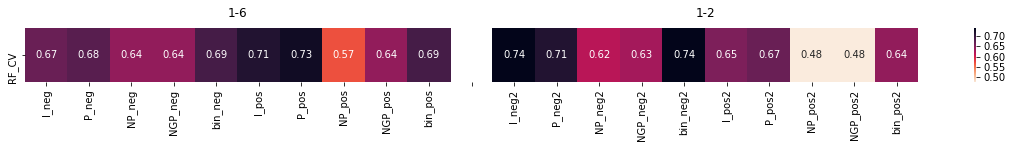

In [111]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Teste_H = pd.concat([Teste_H.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Teste_H.iloc[:,10:]], axis = 1)
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])
plt.text(5,-0.2,'1-6', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'1-2', fontsize  = 12, horizontalalignment='center')
plt.show()

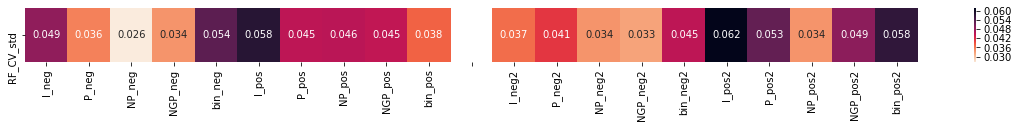

In [112]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Teste_std_H = pd.concat([Teste_std_H.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Teste_std_H.iloc[:,10:]], 
                        axis = 1)
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

In [113]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys(), columns = ['Accuracy']).T
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Teste_ic = Teste_std_H / (100**0.5)*1.96

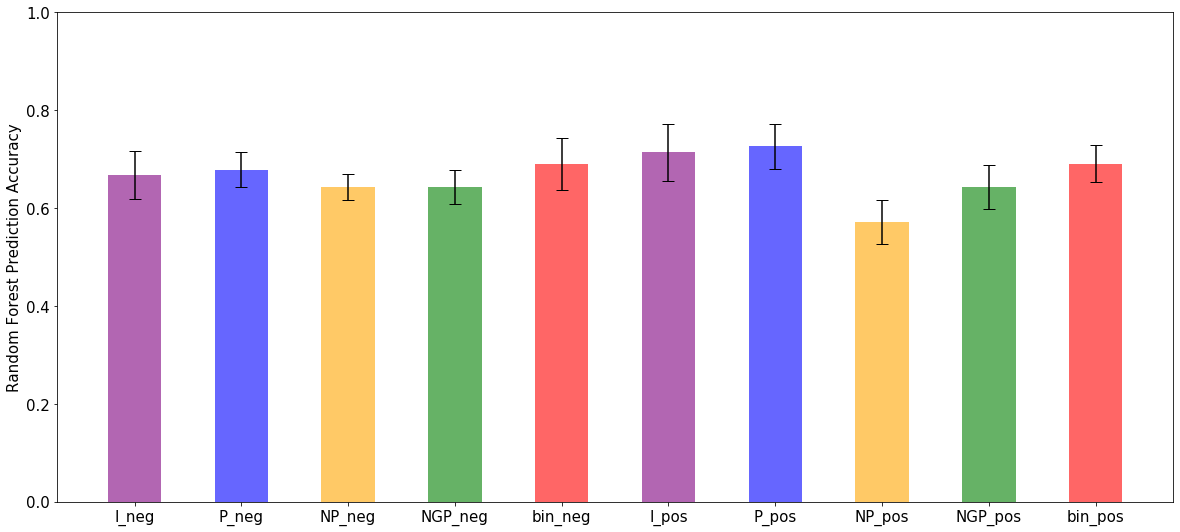

In [114]:
#sns.set_context('notebook')
f, ax = plt.subplots(figsize=(20, 9))

color = ['purple','blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'][0:10], x = Teste_H.columns[0:10], width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns[0:10], y = Teste_H.T['Accuracy'][0:10], yerr = Teste_std_H.iloc[0,:10], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show() #This is with median

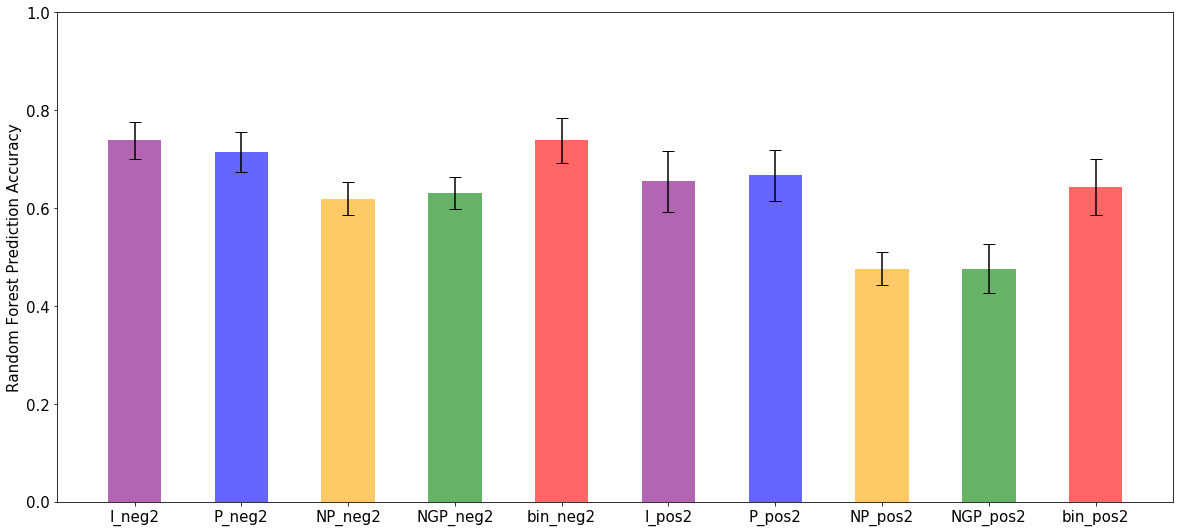

In [115]:
f, ax = plt.subplots(figsize=(20, 9))

color = ['purple','blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'][10:], x = Teste_H.columns[10:], width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns[10:], y = Teste_H.T['Accuracy'][10:], yerr = Teste_std_H.iloc[0,10:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show() #This is with median

#### Applications of different methods

### Attempt/Method nº1 - Direct

### Simple application of random forests

Since the dataset is small, the random forest classification is iterated n times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained - number of random forests can be decided by iter_num. This is the same for all methods. 

To offset the small dataset, 3-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/accuracy (3-fold since that is maximum number possible since every group of samples only has 3 replicates.

Besides the 3-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weigth) is extracted from the forests "built".

Now to run the random forests on the different datasets (negative and positive of both alignments) both in their "normal" and "binary" matrices form. For the normal or euclidean matrices, only the data concerning the P data processing was used since it was the best performer of all former methods employed.

Application of the function `simple_RF` from multianalysis.

In [116]:
#Preparations of dicts:
Scores = {}
Scores_std = {}
Imp_feat = {}

In [117]:
part = {}

part['P_neg'] = treat_neg['P']
part['P_pos'] = treat_pos['P']
part['P_neg2'] = treat_neg2['P']
part['P_pos2'] = treat_pos2['P']
part['bin_neg'] = treat_neg['binary']
part['bin_pos'] = treat_pos['binary']
part['bin_neg2'] = treat_neg2['binary']
part['bin_pos2'] = treat_pos2['binary']

In [118]:
for name, data in part.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data)#, iter_num = 100)
    Scores[name] = np.mean(rf)
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done') 

Fitting random forest for P_neg ...done
Fitting random forest for P_pos ...done
Fitting random forest for P_neg2 ...done
Fitting random forest for P_pos2 ...done
Fitting random forest for bin_neg ...done
Fitting random forest for bin_pos ...done
Fitting random forest for bin_neg2 ...done
Fitting random forest for bin_pos2 ...done


### Attempt/Method nº2 - SMOTE - Code in markdown, not relevant anymore - maybe take out in next version?

### Oversampling data with SMOTE before splitting cross-validation groups. Expected better results due to bleed.

All the same specifications as method nº1 but with an oversampling of the data that doubles the amount of samples (from 39 to 78) which means each cross-valdiation group will have 2 replicates for each variety instead of one.

As mentioned in the title, this means there will be a "bleeding" of the data between test and training groups due to the samples in the test group having been originated from the ones in the training group or have been used to originate data in training groups. Therefore, the score of this method should be higher than the other due to an overestimation of how good the model is due to this bleeding.

SMOTE oversampling is performed in the initial imputated data by the function fast_SMOTE from multianalysis.py. 

Therefore we have to run the NGP data processing again for each dataset.

#Neg1
Imp_S_neg = ma.fast_SMOTE(Imputated_neg)
#Norm_S_neg = sca.Norm_Feat(Imp_S_neg, 554.26202)
#glog_S_neg = sca.glog(Norm_S_neg)
Euc_P_S_neg = sca.ParetoScal(Imp_S_neg)#glog_S_neg)
#Neg2
Imp_S_neg2 = ma.fast_SMOTE(Imputated_neg2)
#Norm_S_neg2 = sca.Norm_Feat(Imp_S_neg2, 554.26202)
#glog_S_neg2 = sca.glog(Norm_S_neg2)
Euc_P_S_neg2 = sca.ParetoScal(Imp_S_neg2)#glog_S_neg2)
#Pos1
Imp_S_pos = ma.fast_SMOTE(Imputated_pos)
#Norm_S_pos = sca.Norm_Feat(Imp_S_pos, 556.2765712820513)
#glog_S_pos = sca.glog(Norm_S_pos)
Euc_P_S_pos = sca.ParetoScal(Imp_S_pos)#glog_S_pos)
#Pos2
Imp_S_pos2 = ma.fast_SMOTE(Imputated_pos2)
#Norm_S_pos2 = sca.Norm_Feat(Imp_S_pos2, 556.2765712820513)
#glog_S_pos2 = sca.glog(Norm_S_pos2)
Euc_P_S_pos2 = sca.ParetoScal(Imp_S_pos2)#glog_S_pos2)
#Binaries
binary_S_neg1 = ma.fast_SMOTE(binary_neg1, binary = True)
binary_S_neg2 = ma.fast_SMOTE(binary_neg2, binary = True)
binary_S_pos1 = ma.fast_SMOTE(binary_pos1, binary = True)
binary_S_pos2 = ma.fast_SMOTE(binary_pos2, binary = True)

N1_B = ma.simple_RF(Euc_P_S_neg)
Scores['neg1-6_bleed'] = np.mean(N1_B[0])
Scores_std['neg1-6_bleed'] = np.std(N1_B[0])
Imp_feat['neg1-6_bleed'] = N1_B[1]

P1_B = ma.simple_RF(Euc_P_S_pos)
Scores['pos1-6_bleed'] = np.mean(P1_B[0])
Scores_std['pos1-6_bleed'] = np.std(P1_B[0])
Imp_feat['pos1-6_bleed'] = P1_B[1]

N2_B = ma.simple_RF(Euc_P_S_neg2)
Scores['neg1-13_bleed'] = np.mean(N2_B[0])
Scores_std['neg1-13_bleed'] = np.std(N2_B[0])
Imp_feat['neg1-13_bleed'] = N2_B[1]

P2_B = ma.simple_RF(Euc_P_S_pos2)
Scores['pos1-13_bleed'] = np.mean(P2_B[0])
Scores_std['pos1-13_bleed'] = np.std(P2_B[0])
Imp_feat['pos1-13_bleed'] = P2_B[1]

BN1_B = ma.simple_RF(binary_S_neg1)
Scores['neg1-6_bin_bleed'] = np.mean(BN1_B[0])
Scores_std['neg1-6_bin_bleed'] = np.std(BN1_B[0])
Imp_feat['neg1-6_bin_bleed'] = BN1_B[1]

BP1_B = ma.simple_RF(binary_S_pos1)
Scores['pos1-6_bin_bleed'] = np.mean(BP1_B[0])
Scores_std['pos1-6_bin_bleed'] = np.std(BP1_B[0])
Imp_feat['pos1-6_bin_bleed'] = BP1_B[1]

BN2_B = ma.simple_RF(binary_S_neg2)
Scores['neg1-13_bin_bleed'] = np.mean(BN2_B[0])
Scores_std['neg1-13_bin_bleed'] = np.std(BN2_B[0])
Imp_feat['neg1-13_bin_bleed'] = BN2_B[1]

BP2_B = ma.simple_RF(binary_S_pos2)
Scores['pos1-13_bin_bleed'] = np.mean(BP2_B[0])
Scores_std['pos1-13_bin_bleed'] = np.std(BP2_B[0])
Imp_feat['pos1-13_bin_bleed'] = BP2_B[1]

### Attempt/Method nº3 - Afterproc (Euclidean); Aftersplit (Binary) - Not relevant anymore
Oversampling data with SMOTE after splitting data and after treatment of data (NGP) (binary matrixes don't have any further processing) - Problem: SMOTE after data processing isn't quite the same as in the beginning of the data (vectors between transformed data in different scale than original)

All the same specifications as method nº1.

#### Still possible although probably not very useful, as for now, it won't be implemented in the notebook (method nº4 is the same but completely excised of the notebook.

Application of the function `RF_M3` from multianalysis.

### Results of the Random Forests surmised in Heatmaps

In [119]:
Scores_H = pd.DataFrame(list(Scores.values()), index = Scores.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

#Inserting blank lines in the DataFrame for better presentation and separation
#Scores_H = pd.concat([Scores_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Scores_H.iloc[:,8:]], axis = 1)
#Scores_std_H = pd.concat([Scores_std_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Scores_std_H.iloc[:,8:]], 
                        #axis = 1)

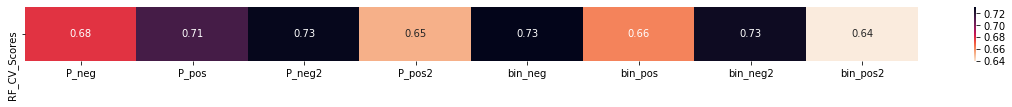

In [120]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])
plt.show()

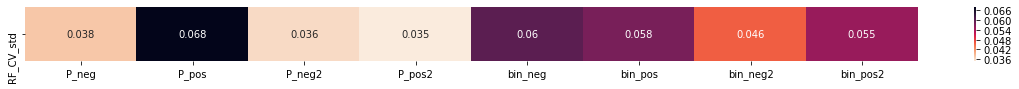

In [121]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive) - Still mean, not median

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

### Alignments 1-6 and 1-2 ("True" Non Bias)

In [122]:
#Getting the number of samples, groups, ratios for each important feature, 
#magnitude for most important feature and calculating % explained by these features (more)
ev = []
magni = []
more = []
for name in Teste_feat:#['neg2-1_direct']:
    if name.endswith('neg'):
        #continue
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        #continue
        Spectra = aligned_all_pos
    elif name.endswith('neg2'):
        #continue
        Spectra = aligned_all_neg2
    elif name.endswith('pos2'):
        #continue
        Spectra = aligned_all_pos2
        
    imp_features = Teste_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra)))
    
    a = 0
    for i in range(number): 
        a = a + imp_features[i][1]*100 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [123]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Teste_feat]) #if '2-1' in i])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:5], line, df.iloc[5:10], line, df.iloc[10:15], line, df.iloc[15:]])

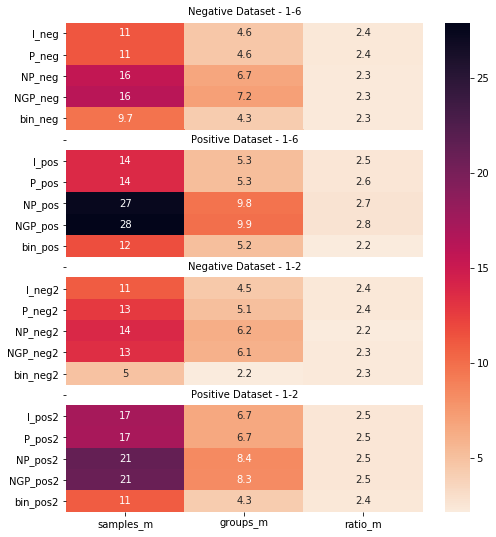

In [124]:
f, ax = plt.subplots(figsize=(8, 9))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'Negative Dataset - 1-6',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,5.5,'Positive Dataset - 1-6',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,11.5,'Negative Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,17.5,'Positive Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.show()

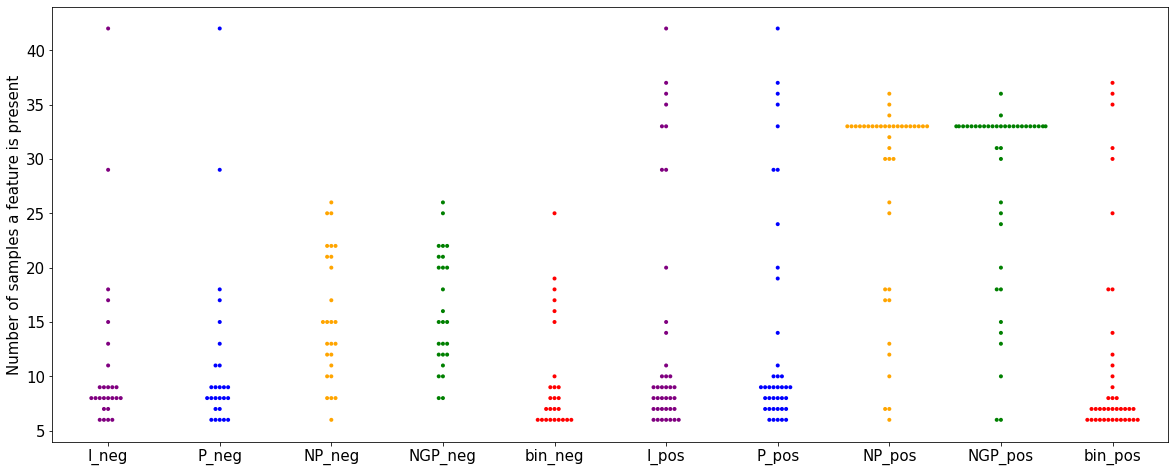

In [125]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[:10], size = 4, palette = ['purple','blue','orange','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))][:10])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

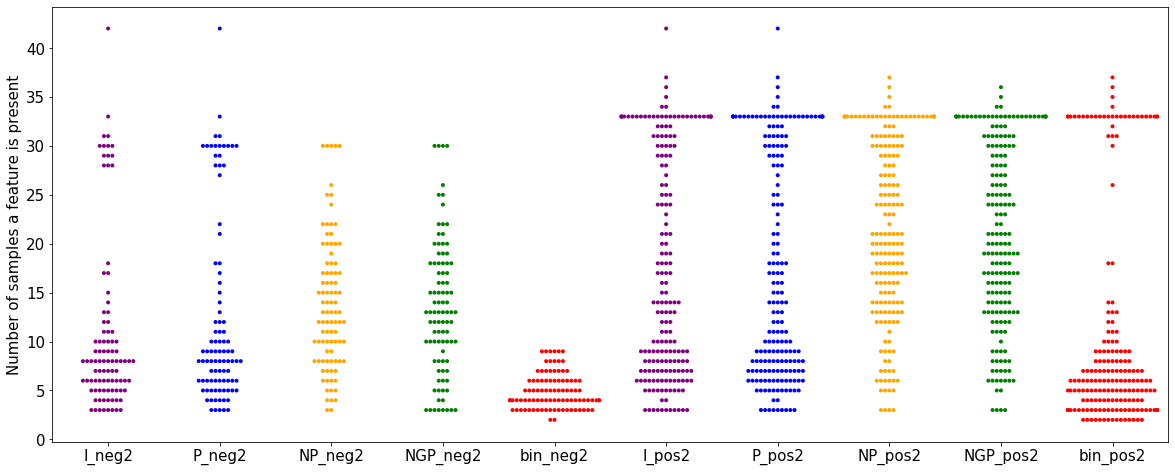

In [126]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[10:], size = 4, palette = ['purple','blue','orange','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))][10:])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [127]:
print('Magnitude of most important feature:', )
for i in range(20):
    print(list(Teste_feat.keys())[i], '     \t', magni[i])
    
print('\n')
print('% of model explained by the 2% most important features')
for i in range(20):
    print(list(Teste_feat.keys())[i], '     \t', more[i])

Magnitude of most important feature:
I_neg      	 5.018975399771679
P_neg      	 5.195703485595326
NP_neg      	 3.3770052264259958
NGP_neg      	 3.3258970764565676
bin_neg      	 3.308357110423031
I_pos      	 8.751347087623099
P_pos      	 8.224398639716846
NP_pos      	 3.7297088111190715
NGP_pos      	 4.01153380020925
bin_pos      	 5.982425801894038
I_neg2      	 9.408785541085729
P_neg2      	 9.272381890211792
NP_neg2      	 5.933447011988363
NGP_neg2      	 6.85335374917578
bin_neg2      	 7.230160652712973
I_pos2      	 17.503558087426555
P_pos2      	 16.52671585947033
NP_pos2      	 10.012613625230529
NGP_pos2      	 10.228406800750033
bin_pos2      	 11.148395432275974


% of model explained by the 2% most important features
I_neg      	 6.545683550142229
P_neg      	 6.593437890966227
NP_neg      	 5.157223916752165
NGP_neg      	 5.189915679753523
bin_neg      	 5.294670248542558
I_pos      	 9.970514913118663
P_pos      	 9.782788555063402
NP_pos      	 6.0730925799269

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [128]:
# Centralize data again excluding the not Imp / Ionly data
datasets = {}

datasets['P_neg'] = treat_neg['P']
datasets['NP_neg'] = treat_neg['NP']
datasets['NGP_neg'] = treat_neg['NGP']
datasets['bin_neg'] = treat_neg['binary']

datasets['P_pos'] = treat_pos['P']
datasets['NP_pos'] = treat_pos['NP']
datasets['NGP_pos'] = treat_pos['NGP']
datasets['bin_pos'] = treat_pos['binary']

datasets['P_neg2'] = treat_neg2['P']
datasets['NP_neg2'] = treat_neg2['NP']
datasets['NGP_neg2'] = treat_neg2['NGP']
datasets['bin_neg2'] = treat_neg2['binary']

datasets['P_pos2'] = treat_pos2['P']
datasets['NP_pos2'] = treat_pos2['NP']
datasets['NGP_pos2'] = treat_pos2['NGP']
datasets['bin_pos2'] = treat_pos2['binary']

### Search for the best number of components to use - Alignment 1-6 and 1-2

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function `optim_PLS` in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [129]:
PLS_optim = {}

In [130]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 50)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for P_neg ...done
Optimizing PLS-DA for NP_neg ...done
Optimizing PLS-DA for NGP_neg ...done
Optimizing PLS-DA for bin_neg ...done
Optimizing PLS-DA for P_pos ...done
Optimizing PLS-DA for NP_pos ...done
Optimizing PLS-DA for NGP_pos ...done
Optimizing PLS-DA for bin_pos ...done
Optimizing PLS-DA for P_neg2 ...done
Optimizing PLS-DA for NP_neg2 ...done
Optimizing PLS-DA for NGP_neg2 ...done
Optimizing PLS-DA for bin_neg2 ...done
Optimizing PLS-DA for P_pos2 ...done
Optimizing PLS-DA for NP_pos2 ...done
Optimizing PLS-DA for NGP_pos2 ...done
Optimizing PLS-DA for bin_pos2 ...done


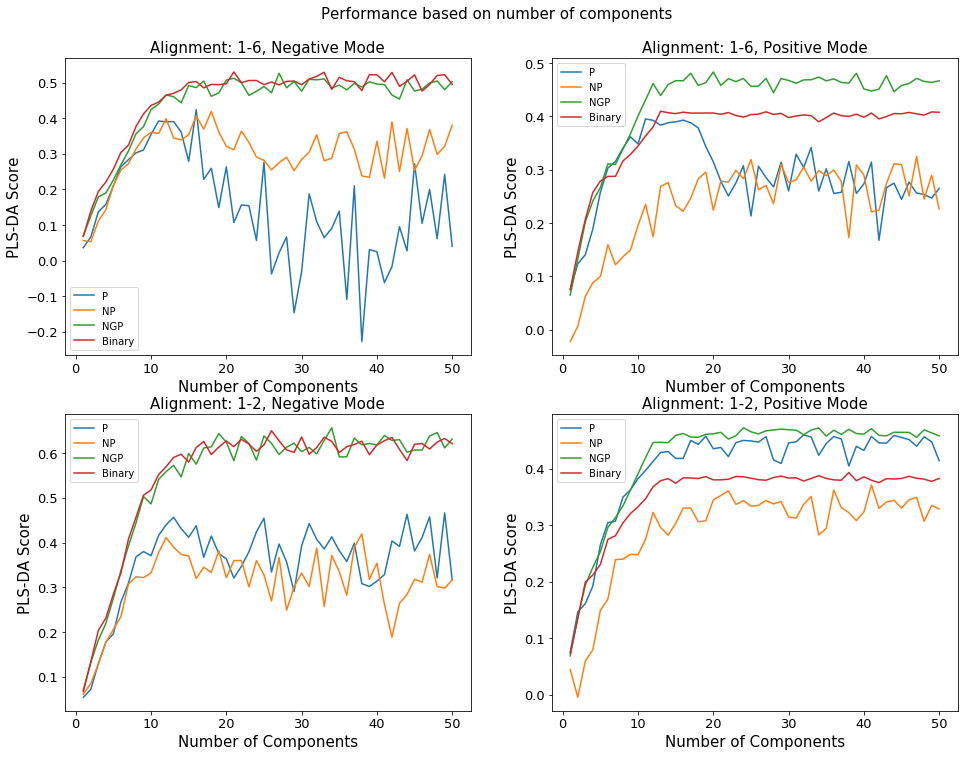

In [131]:
f, axes = plt.subplots(2, 2, figsize = (16,12))
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
plt.suptitle('Performance based on number of components', fontsize = 15, x = 0.5, y = 0.94)

for name, data in PLS_optim.items():
    if name.endswith('neg'):
        quadrant[0].plot(range(1,51),data)
        quadrant[0].set_xlabel('Number of Components', fontsize=15)
        quadrant[0].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[0].set_title('Alignment: 1-6, Negative Mode', fontsize=15)
        quadrant[0].tick_params(axis='both', which='major', labelsize=13)
        quadrant[0].legend(('P', 'NP', 'NGP', 'Binary'))
    if name.endswith('pos'):
        quadrant[1].plot(range(1,51),data)
        quadrant[1].set_xlabel('Number of Components', fontsize=15)
        quadrant[1].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[1].set_title('Alignment: 1-6, Positive Mode', fontsize=15)
        quadrant[1].tick_params(axis='both', which='major', labelsize=13)
        quadrant[1].legend(('P', 'NP', 'NGP', 'Binary'))
    if name.endswith('neg2'):
        quadrant[2].plot(range(1,51),data)
        quadrant[2].set_xlabel('Number of Components', fontsize=15)
        quadrant[2].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[2].set_title('Alignment: 1-2, Negative Mode', fontsize=15)
        quadrant[2].tick_params(axis='both', which='major', labelsize=13)
        quadrant[2].legend(('P', 'NP', 'NGP', 'Binary'))
    if name.endswith('pos2'):
        quadrant[3].plot(range(1,51),data)
        quadrant[3].set_xlabel('Number of Components', fontsize=15)
        quadrant[3].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[3].set_title('Alignment: 1-2, Positive Mode', fontsize=15)
        quadrant[3].tick_params(axis='both', which='major', labelsize=13)
        quadrant[3].legend(('P', 'NP', 'NGP', 'Binary'))

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better when it reached around 15. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [132]:
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [133]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 15, iter_num = 100, feat_type = 'Coef')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done')    

Fitting PLS-DA for P_neg ...done
Fitting PLS-DA for NP_neg ...done
Fitting PLS-DA for NGP_neg ...done
Fitting PLS-DA for bin_neg ...done
Fitting PLS-DA for P_pos ...done
Fitting PLS-DA for NP_pos ...done
Fitting PLS-DA for NGP_pos ...done
Fitting PLS-DA for bin_pos ...done
Fitting PLS-DA for P_neg2 ...done
Fitting PLS-DA for NP_neg2 ...done
Fitting PLS-DA for NGP_neg2 ...done
Fitting PLS-DA for bin_neg2 ...done
Fitting PLS-DA for P_pos2 ...done
Fitting PLS-DA for NP_pos2 ...done
Fitting PLS-DA for NGP_pos2 ...done
Fitting PLS-DA for bin_pos2 ...done


### Alignment 1-6

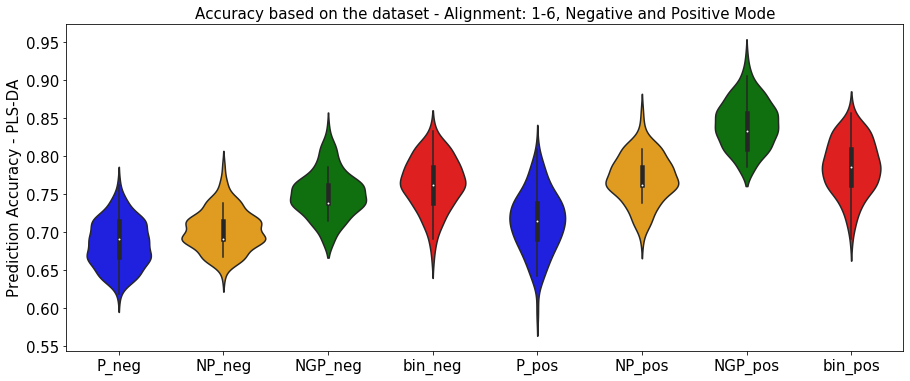

In [134]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['blue','orange','green','red']
data=pd.DataFrame.from_dict(PLS_accu).iloc[:,:8]
sns.violinplot(data=data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
plt.title('Accuracy based on the dataset - Alignment: 1-6, Negative and Positive Mode', fontsize = 15)
plt.show()

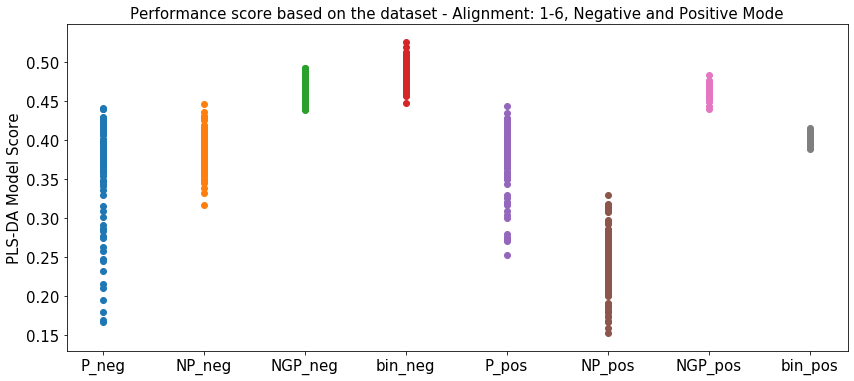

In [135]:
f, ax = plt.subplots(figsize=(14,6))
for name, data in PLS_score.items():
    if not name.endswith('2'):
        plt.scatter([name]*len(data), data)
plt.ylabel('PLS-DA Model Score', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Performance score based on the dataset - Alignment: 1-6, Negative and Positive Mode', fontsize = 15)
plt.show()

### Alignment 1-2

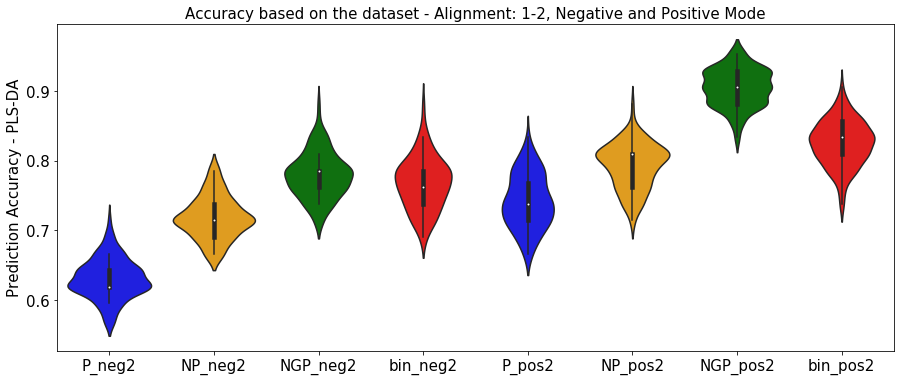

In [136]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['blue','orange','green','red']
data=pd.DataFrame.from_dict(PLS_accu).iloc[:,8:]
sns.violinplot(data=data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
plt.title('Accuracy based on the dataset - Alignment: 1-2, Negative and Positive Mode', fontsize = 15)
plt.show()

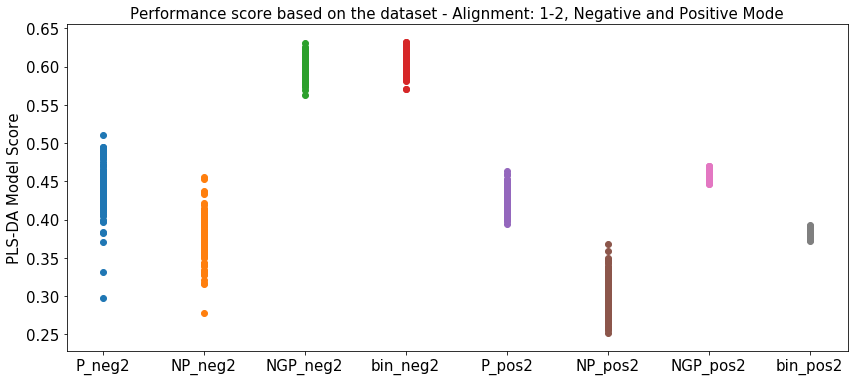

In [137]:
f, ax = plt.subplots(figsize=(14,6))
for name, data in PLS_score.items():
    if name.endswith('2'):
        plt.scatter([name]*len(data), data)
plt.ylabel('PLS-DA Model Score', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Performance score based on the dataset - Alignment: 1-2, Negative and Positive Mode', fontsize = 15)
plt.show()

### Accuracies and Scores Summary - With Medians but also still with standard deviations

In [138]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.median(PLS_accu[name])
    Score[name] = np.median(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

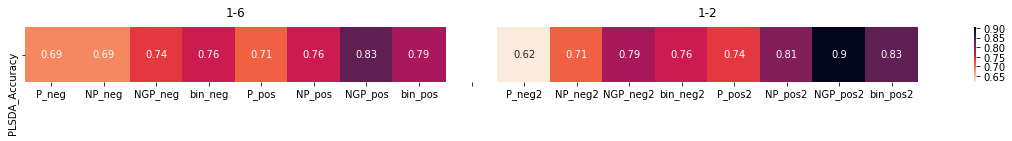

In [139]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Accuracy_H = pd.concat([Accuracy_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Accuracy_H.iloc[:,8:]], axis = 1)

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

plt.text(4,-0.2,'1-6', fontsize  = 12, horizontalalignment='center')
plt.text(13,-0.2,'1-2', fontsize  = 12, horizontalalignment='center')
plt.show()

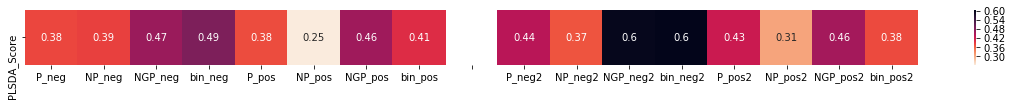

In [140]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Score_H = pd.concat([Score_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Score_H.iloc[:,8:]], axis = 1)

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [141]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).iloc[:8].T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())[:8]
Accuracy_H.T

Accuracy        SD
P_neg    0.690476  0.029951
NP_neg   0.690476  0.026402
NGP_neg  0.738095  0.030023
bin_neg  0.761905  0.033614
P_pos    0.714286  0.039412
NP_pos   0.761905  0.030956
NGP_pos  0.833333  0.031407
bin_pos  0.785714  0.034980

In [142]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).iloc[:8].T
Score_H.loc['SD'] = list(Score_std.values())[:8]
Score_H.T

Score        SD
P_neg    0.383407  0.064370
NP_neg   0.388155  0.023727
NGP_neg  0.466899  0.013124
bin_neg  0.489849  0.014722
P_pos    0.379911  0.038568
NP_pos   0.245588  0.038742
NGP_pos  0.461630  0.007963
bin_pos  0.405152  0.004822

### Characteristics of the most important features - still mean (not median)

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [143]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []

for name in PLS_feat:
    if name.endswith('neg'):
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        Spectra = aligned_all_pos
    elif name.endswith('neg2'):
        Spectra = aligned_all_neg2
    elif name.endswith('pos2'):
        Spectra = aligned_all_pos2
    
    imp_features = PLS_feat[name]
    
    index.append(name)
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    total_m = 0
    
    for i in range(len(imp_features)):
        total_m = total_m + imp_features[i][1]
    magni.append(imp_features[0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [144]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8], line, df.iloc[8:12], line, df.iloc[12:]])

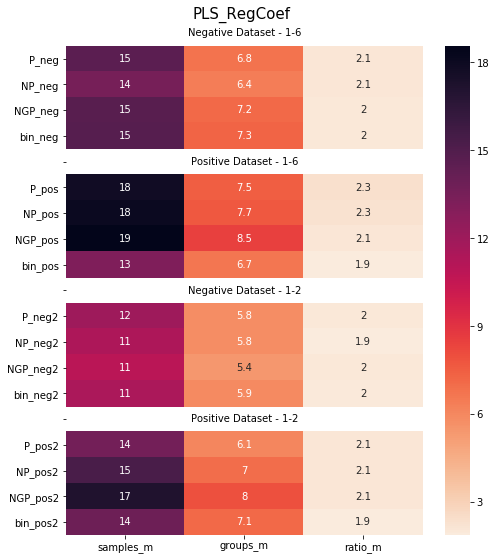

In [145]:
f, ax = plt.subplots(figsize=(8, 9))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('PLS_RegCoef', fontsize = 15, x = 0.43, y = 0.94)
plt.text(1.5,-0.5,'Negative Dataset - 1-6',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset - 1-6',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,9.5,'Negative Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,14.5,'Positive Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.show()

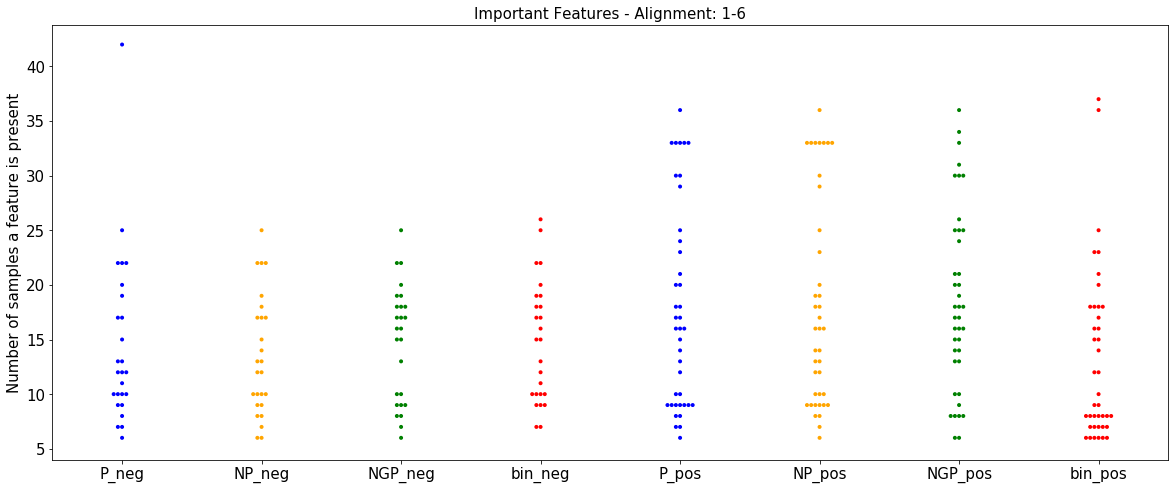

In [146]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#sns.violinplot(data=data)
sns.swarmplot(data=data[:8], size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_feat.keys())[i] for i in range(len(PLS_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.title('Important Features - Alignment: 1-6', fontsize = 15)
plt.show()

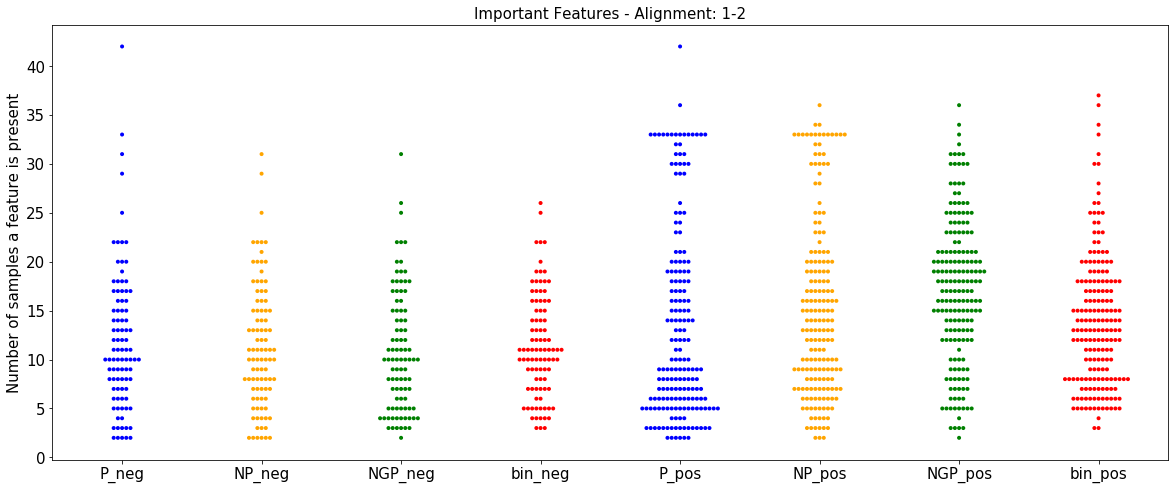

In [147]:
f, ax = plt.subplots(figsize=(20,8))
#sns.violinplot(data=data)
sns.swarmplot(data=data[8:], size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_feat.keys())[i] for i in range(len(PLS_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.title('Important Features - Alignment: 1-2', fontsize = 15)
plt.show()

In [148]:
print('Magnitude of most important features for each case:')
for i in range(16):
    print(list(PLS_feat.keys())[i], '     \t', magni[i])

Magnitude of most important features for each case:
P_neg      	 9.544931485066623
NP_neg      	 12.172523769854692
NGP_neg      	 5.749519693942015
bin_neg      	 3.402948415565062
P_pos      	 16.17870583240635
NP_pos      	 6.999592038764574
NGP_pos      	 4.712242620220844
bin_pos      	 4.482293966662164
P_neg2      	 18.407106064811423
NP_neg2      	 26.33679462415494
NGP_neg2      	 7.8727480101080625
bin_neg2      	 4.345952232022239
P_pos2      	 27.16591398333843
NP_pos2      	 16.80422211603583
NGP_pos2      	 8.98938151155601
bin_pos2      	 4.8705567234048806


### Example of models built with the full dataset and sample representation on the two most important Components/Latent Variables

In [149]:
def plot_PLSDA(principaldf, label_colors, components=(1,2), title="PLS-DA", ax=None):
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        #ax.axis('equal')
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1)
        ax.set_title(title, fontsize=15)

#### NGP data treatment for the Negative Mode - Alignment: 1-6

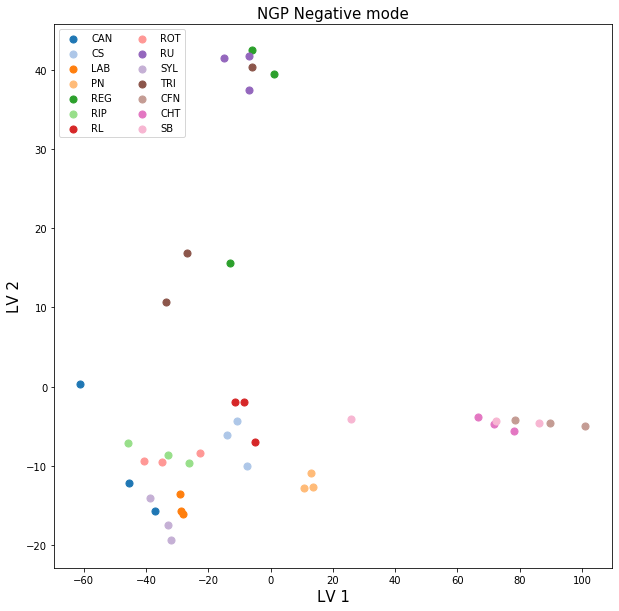

In [150]:
n_components = 15

plsreg_GPneg = ma.PLSscores_with_labels(NGP_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### Binary processed data for the negative mode - Alignment: 1-6

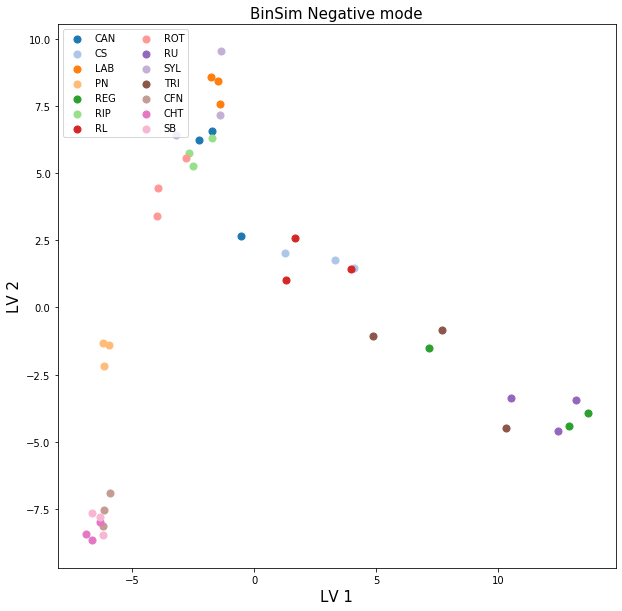

In [151]:
n_components = 15

plsreg_GPneg = ma.PLSscores_with_labels(aligned_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### NGP data treatment for the Negative Mode - Alignment: 1-2

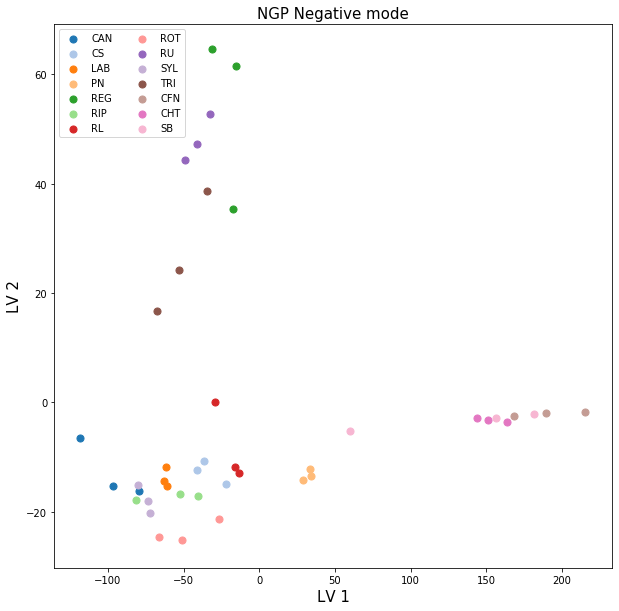

In [152]:
n_components = 15

plsreg_GPneg = ma.PLSscores_with_labels(NGP_neg2, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### Binary processed data for the negative mode - Alignment: 1-2

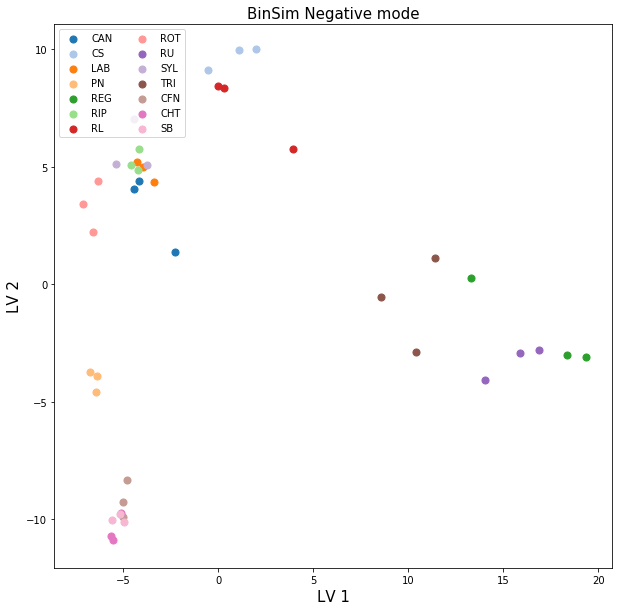

In [153]:
n_components = 15

plsreg_GPneg = ma.PLSscores_with_labels(aligned_neg2, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is random forests or pls-da found a significant class structure in the data. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 150 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Use of function `permutation_RF` in multianalysis.py

In [154]:
CV = {}
PMs = {}
pvalue = {}

In [155]:
all_data = (P_neg, NP_neg, NGP_neg, aligned_neg, P_pos, NP_pos, NGP_pos, aligned_pos,
           P_neg2, NP_neg2, NGP_neg2, aligned_neg2, P_pos2, NP_pos2, NGP_pos2, aligned_pos2)
names = ('P_neg', 'NP_neg', 'NGP_neg', 'bin_neg', 'P_pos', 'NP_pos', 'NGP_pos', 'bin_pos',
        'P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2', 'P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for P_neg ...
Done!
Permutation test (Random Forest) for NP_neg ...
Done!
Permutation test (Random Forest) for NGP_neg ...
Done!
Permutation test (Random Forest) for bin_neg ...
Done!
Permutation test (Random Forest) for P_pos ...
Done!
Permutation test (Random Forest) for NP_pos ...
Done!
Permutation test (Random Forest) for NGP_pos ...
Done!
Permutation test (Random Forest) for bin_pos ...
Done!
Permutation test (Random Forest) for P_neg2 ...
Done!
Permutation test (Random Forest) for NP_neg2 ...
Done!
Permutation test (Random Forest) for NGP_neg2 ...
Done!
Permutation test (Random Forest) for bin_neg2 ...
Done!
Permutation test (Random Forest) for P_pos2 ...
Done!
Permutation test (Random Forest) for NP_pos2 ...
Done!
Permutation test (Random Forest) for NGP_pos2 ...
Done!
Permutation test (Random Forest) for bin_pos2 ...
Done!


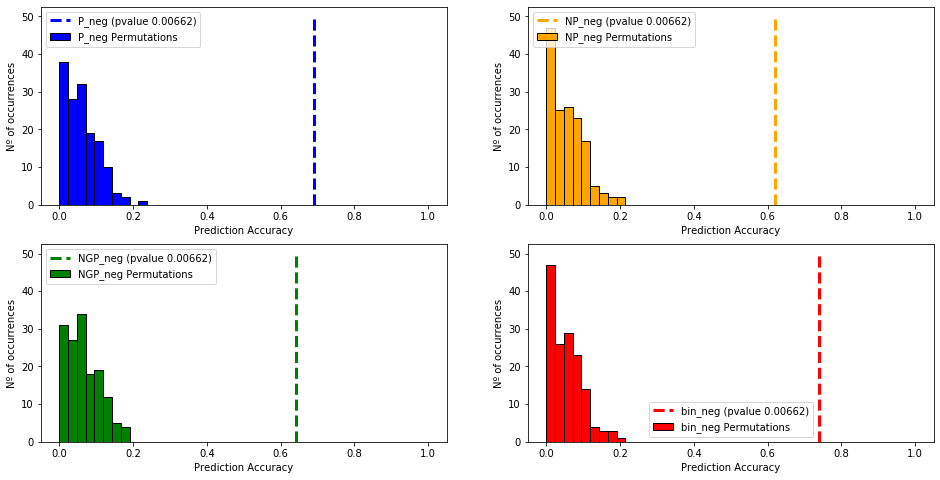

In [156]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_neg', 'NP_neg', 'NGP_neg', 'bin_neg']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

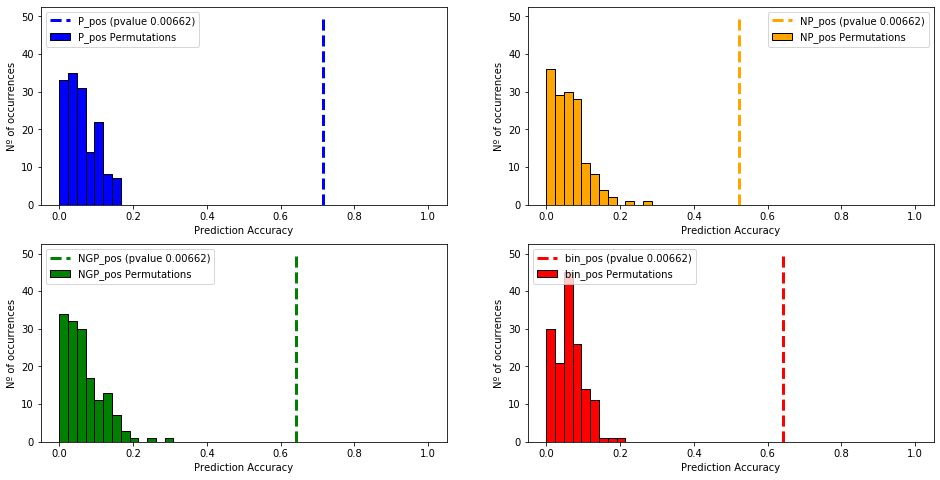

In [157]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos', 'NP_pos', 'NGP_pos', 'bin_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

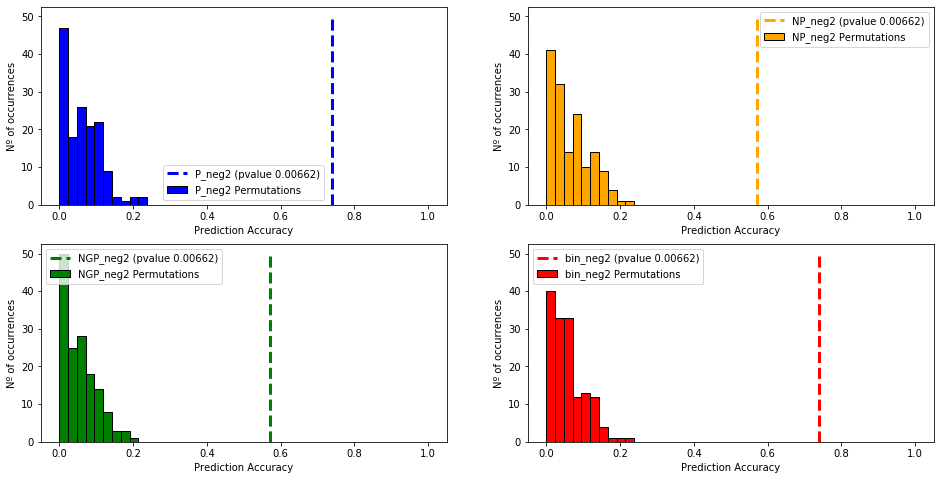

In [158]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg2.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

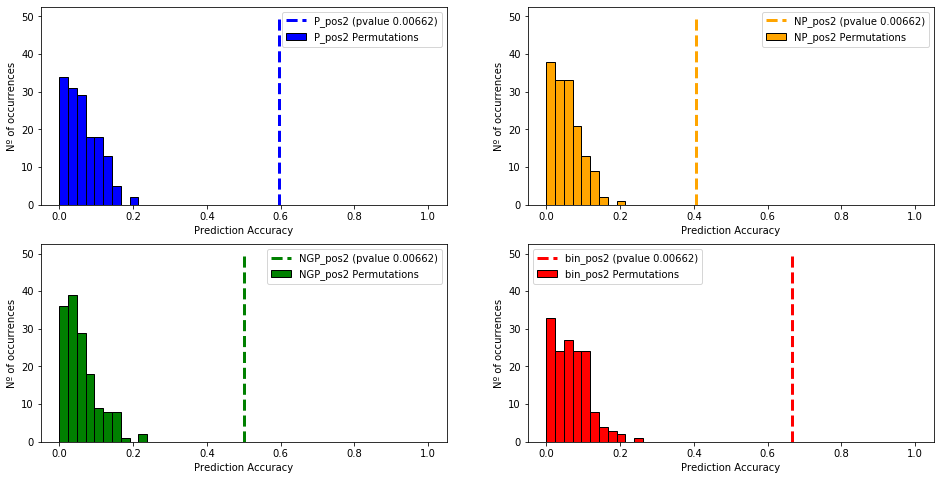

In [159]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos2.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [160]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [161]:
all_data = (P_neg, NP_neg, NGP_neg, aligned_neg, P_pos, NP_pos, NGP_pos, aligned_pos,
           P_neg2, NP_neg2, NGP_neg2, aligned_neg2, P_pos2, NP_pos2, NGP_pos2, aligned_pos2)
names = ('P_neg', 'NP_neg', 'NGP_neg', 'bin_neg', 'P_pos', 'NP_pos', 'NGP_pos', 'bin_pos',
        'P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2', 'P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2')

for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=15, iter_num=150)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for P_neg ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NP_neg ...
Done!
permutation test (PLS-DA) for NGP_neg ...
Done!
permutation test (PLS-DA) for bin_neg ...
Done!
permutation test (PLS-DA) for P_pos ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NP_pos ...
Done!
permutation test (PLS-DA) for NGP_pos ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for bin_pos ...
Done!
permutation test (PLS-DA) for P_neg2 ...
Done!
permutation test (PLS-DA) for NP_neg2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NGP_neg2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for bin_neg2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for P_pos2 ...
Done!
permutation test (PLS-DA) for NP_pos2 ...
Done!
permutation test (PLS-DA) for NGP_pos2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for bin_pos2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!


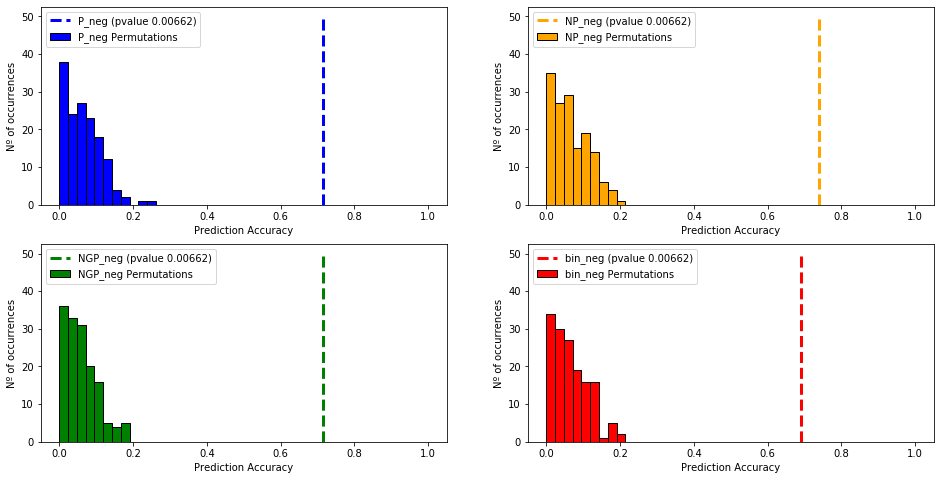

In [162]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_neg', 'NP_neg', 'NGP_neg', 'bin_neg']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

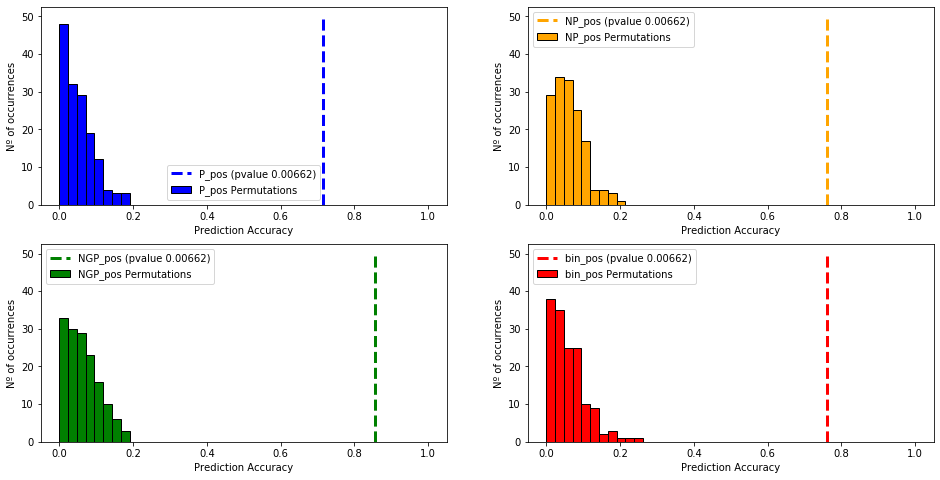

In [163]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos', 'NP_pos', 'NGP_pos', 'bin_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

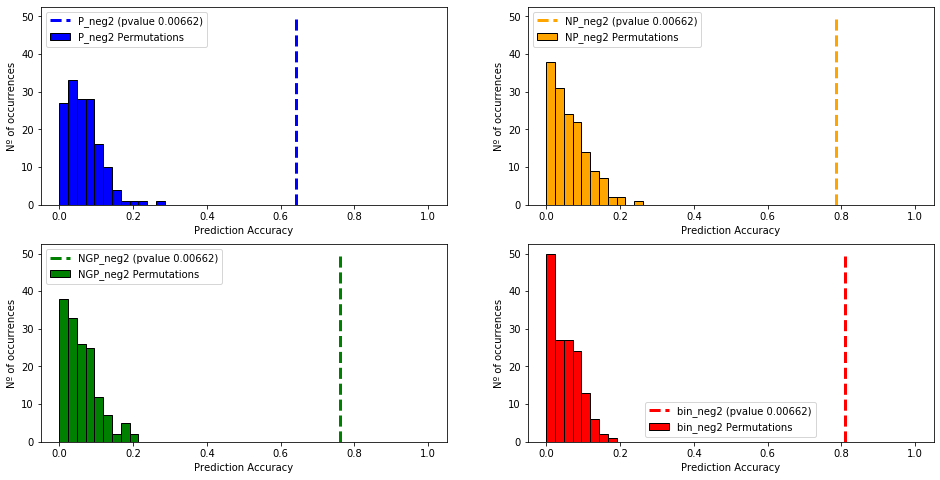

In [164]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg2.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

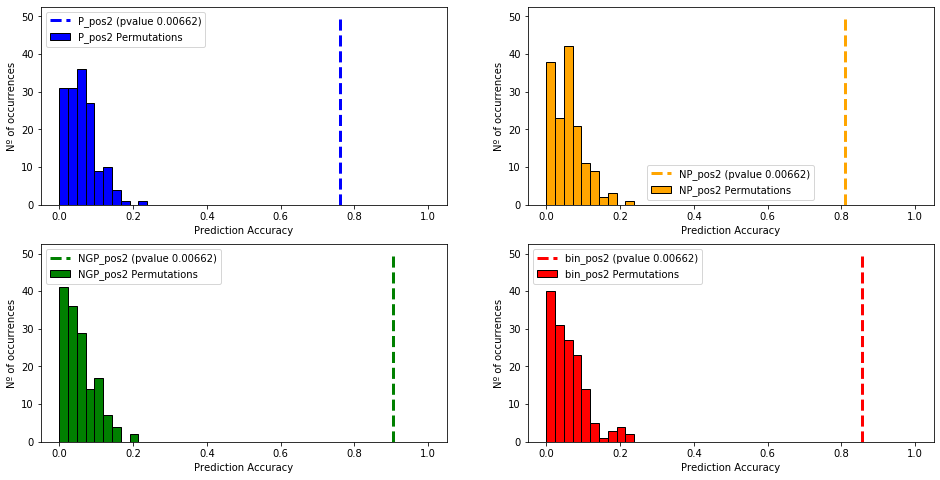

In [165]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos2.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Other things

In [166]:
#matrix = pd.DataFrame(np.zeros((39,13)))
#for i in range(13):
#    matrix.iloc[3*i:3*i+3,i] = 1

from sklearn.model_selection import KFold, StratifiedKFold
CVs = []
CVr2s = []
MSEs = []

for i in range(1,50):
    cv = []
    cvr2 = []
    mse = []
    kf = StratifiedKFold(3, shuffle = True)
    for train_index, test_index in kf.split(Euc_NGP_neg2.data.T, Euc_NGP_neg2.labels):
        #print("TRAIN:", train_index, "TEST:", test_index)
        plsda = PLSRegression(n_components = i)
        #plsda.fit(X=Euc_NGP_neg.data.T,Y=matrix)
        X_train, X_test = Euc_NGP_neg2.data[Euc_P_neg2.data.columns[train_index]].T, Euc_NGP_neg2.data[Euc_P_neg.data.columns[test_index]].T
        y_train, y_test = matrix.T[matrix.T.columns[train_index]].T, matrix.T[matrix.T.columns[test_index]].T
        plsda.fit(X=X_train,Y=y_train)
        cv.append(plsda.score(X_test,y_test))
        cvr2.append(r2_score(plsda.predict(X_test), y_test))
        y_pred = plsda.predict(X_test)
        mse.append(mean_squared_error(y_test, y_pred))
    CVs.append(np.mean(cv))
    CVr2s.append(np.mean(cvr2))
    MSEs.append(np.mean(mse))

f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,50),CVs)

plsda = PLSRegression(n_components = 25)
plsda.fit(X=Euc_NGP_neg2.data.T,Y=matrix)

cv = []
cvr2 = []
mse = []
kf = StratifiedKFold(3, shuffle = True)
certo = 0
for train_index, test_index in kf.split(Euc_NGP_neg2.data.T, Euc_NGP_neg2.labels):
        #print("TRAIN:", train_index, "TEST:", test_index)
    plsda = PLSRegression(n_components = 25)
    #plsda.fit(X=Euc_NGP_neg.data.T,Y=matrix)
    X_train, X_test = Euc_NGP_neg2.data[Euc_NGP_neg2.data.columns[train_index]].T, Euc_NGP_neg2.data[Euc_NGP_neg2.data.columns[test_index]].T
    y_train, y_test = matrix.T[matrix.T.columns[train_index]].T, matrix.T[matrix.T.columns[test_index]].T
    plsda.fit(X=X_train,Y=y_train)
    cv.append(plsda.score(X_test,y_test))
    cvr2.append(r2_score(plsda.predict(X_test), y_test))
    y_pred = plsda.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
    for i in range(len(y_pred)):
        if list(y_test[i]).index(max(y_test[i])) == np.argmax(y_pred[i]):
            certo = certo + 1
print(certo/len(Euc_NGP_neg.labels))

In [167]:
def read_aligned_files(filename):
    """Short function to read the aligned files fast while putting the MultiIndex in the correct order for the CDL accessor."""
    df = pd.read_csv(filename, header = None, index_col = [0])
    df.index.name = 'm/z'
    mi = pd.concat([df.iloc[1, :],df.iloc[0, :]], axis = 'columns')
    mi = pd.MultiIndex.from_frame(mi)
    final_file = pd.read_csv(filename, header = [0,1], index_col = [0])
    final_file.columns = mi
    return final_file